# Spatial Modelling

## Introduction: From Exploratory Analysis to Spatial Modelling

The previous notebook focused on exploratory spatial analysis of residential land prices and transport accessibility in Prague. Its primary objective was to determine whether spatial dependence and spatial heterogeneity are present in the data and whether they are sufficiently strong to warrant the use of spatial modelling techniques.

Through a combination of non-spatial exploratory analysis and explicit spatial diagnostics, strong evidence of spatial structure was identified. Global Moran’s I statistics revealed statistically significant positive spatial autocorrelation in land prices and in all transport accessibility measures, while Local Indicators of Spatial Association (LISA) exposed coherent spatial regimes and transition zones that correspond closely to known urban and infrastructural patterns. Furthermore, cluster-conditioned scatter plots demonstrated that the relationship between land prices and accessibility differs systematically across space, indicating spatially varying marginal effects.

These findings imply that standard aspatial regression models are likely to violate key assumptions, particularly the independence of observations and the spatial stationarity of coefficients. As a result, purely global regression approaches risk producing biased, inefficient, or misleading estimates.

Building on this foundation, the present notebook marks the transition from exploratory analysis to formal regression modelling. The first step is the estimation of baseline global models using Ordinary Least Squares (OLS), serving both as a benchmark and as a diagnostic reference. Model residuals and diagnostics will be examined to assess remaining spatial dependence and model misspecification.

Subsequently, the analysis will move toward explicitly spatial modelling approaches. These include spatial econometric models that account for spatial dependence in the dependent variable or error term, as well as spatially varying coefficient models designed to capture local heterogeneity in the relationship between land prices and transport accessibility. Throughout this process, the emphasis is not on maximizing predictive performance, but on understanding spatial mechanisms, interpreting model behavior, and assessing the implications for urban structure and transport-related value capitalization.

Together, this notebook initiates the regression modelling phase of the project, providing a structured and theoretically motivated pathway from exploratory spatial patterns to interpretable spatial models that can inform urban and transport policy analysis.

## Loading the dataset

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

DATA_DIR = "data/processed"
PRICE_PATH = f"{DATA_DIR}/price_residential_prague_nearest_stops_by_mode.gpkg"

price = gpd.read_file(PRICE_PATH)

print(price.columns)
print(len(price))


Index(['CENA', 'price_area', 'res_share', 'nearest_tram_id', 'dist_tram_m',
       'nearest_metro_id', 'dist_metro_m', 'nearest_bus_id', 'dist_bus_m',
       'nearest_rail_id', 'dist_rail_m', 'geometry'],
      dtype='str')
5728


In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np

DATA_DIR = "data/processed"
PRICE_PATH = f"{DATA_DIR}/price_residential_prague_nearest_stops_by_mode.gpkg"

price = gpd.read_file(PRICE_PATH).copy()

# --- 1) Rename + numeric cleaning (aby se modelovalo pohodlně) ---
price = price.rename(columns={
    "CENA": "price_czk_m2"
})

# CENA někdy bývá string -> bezpečný převod
price["price_czk_m2"] = pd.to_numeric(price["price_czk_m2"], errors="coerce")

# --- 2) Basic filters (minimální, ať si nevystřelíme nohu) ---
# ceny > 0, vzdálenosti >= 0, plocha > 0
price = price[
    (price["price_czk_m2"] > 0) &
    (price["price_area"] > 0) &
    (price["dist_tram_m"] >= 0) &
    (price["dist_metro_m"] >= 0) &
    (price["dist_bus_m"] >= 0) &
    (price["dist_rail_m"] >= 0)
].copy()

# --- 3) Logs (stabilní specifikace pro OLS i spatial) ---
# log(1 + distance) aby nebyl problém s nulami
for col in ["dist_tram_m","dist_metro_m","dist_bus_m","dist_rail_m"]:
    price[f"log_{col}"] = np.log1p(price[col])

price["log_price"] = np.log(price["price_czk_m2"])
price["log_area"]  = np.log(price["price_area"])

# --- 4) Quick sanity report ---
print("N after cleaning:", len(price))
print(price[["price_czk_m2","log_price","price_area","log_area",
             "dist_metro_m","dist_tram_m","dist_bus_m","dist_rail_m"]].describe().T)

# volitelně: missingness
print("\nMissing values (top):")
print(price.isna().sum().sort_values(ascending=False).head(12))


N after cleaning: 4871
               count          mean           std         min          25%  \
price_czk_m2  4871.0  14412.412236   7996.151237  700.000000  9970.000000   
log_price     4871.0      9.448213      0.519320    6.551080     9.207336   
price_area    4871.0  25667.321774  48049.298837  438.748450  5018.971898   
log_area      4871.0      9.367949      1.195717    6.083926     8.520980   
dist_metro_m  4871.0   2232.014512   2135.017362    3.399639   674.731931   
dist_tram_m   4871.0   1741.644147   1984.668881    3.485493   291.605147   
dist_bus_m    4871.0    187.134886    129.345965    1.489560    96.943327   
dist_rail_m   4871.0   1421.876744    944.720332   40.550519   770.064699   

                       50%           75%            max  
price_czk_m2  13740.000000  18000.000000  102420.000000  
log_price         9.528067      9.798127      11.536837  
price_area    10805.367262  25183.693972  671635.640052  
log_area          9.287798     10.133951      13.41

## Fitting OLS model

Before introducing explicit spatial regression techniques, we begin with a baseline Ordinary Least Squares (OLS) model. 

The purpose of this step is not to identify a final or fully adequate model of land price formation, but to establish a transparent reference point against which the necessity and contribution of spatial modelling can be evaluated.

OLS provides a familiar and interpretable framework for examining the average (global) relationship between residential land prices and transport accessibility. 

In particular, it allows us to assess the direction, magnitude, and statistical significance of accessibility effects under the simplifying assumption that these effects are constant across space and that observations are independent. 

These assumptions are known to be strong and, based on the preceding exploratory analysis, likely violated in the present context.

Nevertheless, fitting an OLS model serves several important diagnostic functions. 

First, it offers a benchmark for coefficient interpretation, enabling comparison with more advanced spatial models introduced later.

Second, it provides residuals that can be explicitly tested for remaining spatial autocorrelation, thereby quantifying the extent to which spatial dependence is left unmodeled. 

Third, it allows us to assess issues such as heteroskedasticity and multicollinearity in a controlled and well-understood setting.

From a modelling perspective, the OLS specification should therefore be interpreted as a controlled simplification rather than a realistic representation of the underlying spatial processes. 

Any systematic spatial patterns observed in the residuals or instability in coefficient estimates should be understood not as modelling failures, but as empirical signals motivating the transition to spatial econometric and spatially varying coefficient models.

In the sections that follow, the OLS model is estimated using log-transformed land prices and accessibility measures. 

The results are evaluated primarily through diagnostics rather than goodness-of-fit, setting the stage for spatial models that explicitly relax the assumptions of independence and spatial stationarity.

### Model Specification

The baseline OLS model is specified to capture the global relationship between residential land prices and transport accessibility while controlling for scale effects related to parcel size. The dependent variable is the logarithm of residential land price per square meter, which stabilizes variance and facilitates elasticity-based interpretation of coefficients.

The explanatory variables include log-transformed distances to the nearest public transport stop by mode (metro, tram, bus, and rail), using a log(1 + distance) transformation to accommodate zero or near-zero distances. Parcel area is included as a control variable in logarithmic form to account for size-related effects that are not directly related to accessibility.

Formally, the model is defined as:

$$
\log(\text{price}_i) =
\beta_0
+ \beta_1 \log(\text{area}_i)
+ \beta_2 \log(1 + d^{\text{metro}}_i)
+ \beta_3 \log(1 + d^{\text{tram}}_i)
+ \beta_4 \log(1 + d^{\text{bus}}_i)
+ \beta_5 \log(1 + d^{\text{rail}}_i)
+ \varepsilon_i,
$$

where $i$ indexes residential land polygons, $d^{\text{mode}}_i$ denotes the Euclidean distance to the nearest stop of the corresponding public transport mode, and $\varepsilon_i$ is an error term assumed to be independently and identically distributed.


This specification imposes two key simplifying assumptions. First, the marginal effect of transport accessibility is assumed to be spatially stationary, meaning that the impact of an additional unit of distance is identical across all locations in the city. 

Second, the error term is assumed to be spatially uncorrelated, implying that unobserved influences on land prices do not spill over across space.

Given the results of the exploratory spatial analysis, both assumptions are expected to be violated. 

The model is therefore intentionally parsimonious and serves as a diagnostic benchmark rather than a substantive description of the spatial price formation process. Deviations from these assumptions, identified through residual diagnostics and coefficient instability, are interpreted as motivation for introducing explicit spatial dependence and spatial heterogeneity in subsequent models.

### Design matrix and model estimation

In [8]:
import statsmodels.api as sm

# --- model variables ---
y = price["log_price"]

X = price[[
    "log_area",
    "log_dist_metro_m",
    "log_dist_tram_m",
    "log_dist_bus_m",
    "log_dist_rail_m"
]].copy()

X = sm.add_constant(X)



In [9]:
# --- fit OLS ---
ols = sm.OLS(y, X, missing="drop").fit()

# robust standard errors (HC1)
ols_hc1 = ols.get_robustcov_results(cov_type="HC1")

print(ols_hc1.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     170.7
Date:                Fri, 06 Feb 2026   Prob (F-statistic):          9.85e-168
Time:                        00:30:34   Log-Likelihood:                -3293.4
No. Observations:                4871   AIC:                             6599.
Df Residuals:                    4865   BIC:                             6638.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.9690      0.100  

The baseline OLS results confirm the presence of meaningful global relationships between residential land prices and transport accessibility, while simultaneously highlighting the limitations of a purely aspatial modelling framework. 

The model explains only a modest share of price variability (R² ≈ 0.16), indicating that land values are largely shaped by localized and spatially structured processes that cannot be captured by a single global specification. 

Accessibility to metro and tram systems exhibits strong and statistically significant negative effects on land prices, consistent with their role as primary capitalization mechanisms in Prague’s public transport network. 

In contrast, bus and rail accessibility show no robust global effects, reflecting their more localized or context-dependent influence rather than true irrelevance. 

Diagnostic statistics further reveal non-normal and positively dependent residuals, as well as structural collinearity between metro and tram variables, underscoring violations of key OLS assumptions. 

Taken together, these results position the OLS model as a diagnostic benchmark rather than a substantive explanation, providing a clear empirical justification for transitioning to spatial econometric and spatially varying coefficient models that explicitly account for spatial dependence and heterogeneity.

### Residuals check

In [13]:
price["ols_fitted"] = ols.fittedvalues
price["ols_resid"]  = ols.resid

price[["log_price","ols_fitted","ols_resid"]].describe().T

count          mean       std       min       25%       50%  \
log_price   4871.0  9.448213e+00  0.519320  6.551080  9.207336  9.528067   
ols_fitted  4871.0  9.448213e+00  0.208052  8.871415  9.296342  9.447773   
ols_resid   4871.0  4.381996e-14  0.475824 -2.486611 -0.189743  0.123272   

                 75%        max  
log_price   9.798127  11.536837  
ols_fitted  9.600377  10.210936  
ols_resid   0.310436   1.706919

The distribution of OLS residuals provides further evidence that the baseline model captures only a coarse global structure in the data. 
    
While the residuals are centered around zero, their dispersion is substantial relative to the variation explained by the fitted values, indicating that a large share of price variability remains unaccounted for.

Moreover, the residual distribution is asymmetric, with a heavier negative tail and a positive median, suggesting systematic over- and under-prediction in specific parts of the city. 

Given the strong spatial clustering identified in the exploratory analysis, these residual patterns are unlikely to represent random noise. 

Instead, they are indicative of unmodeled spatial processes and localized effects that vary across urban contexts.

These observations reinforce the expectation that residuals are spatially dependent, motivating formal testing for spatial autocorrelation and the transition to models that explicitly account for spatial structure.


#### Spatial distribution of residuals

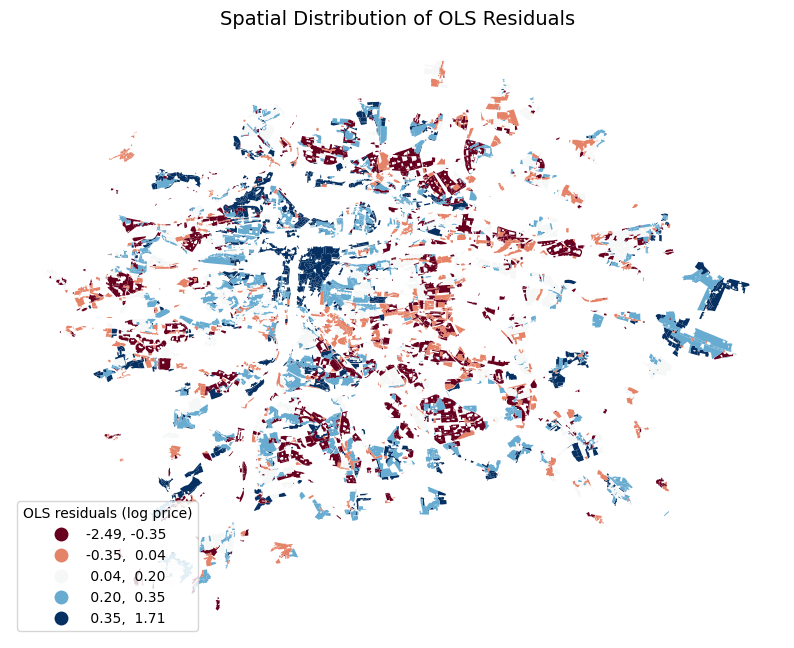

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="ols_resid",
    cmap="RdBu",
    scheme="quantiles",
    k=5,
    linewidth=0,
    legend=True,
    legend_kwds={
        "title": "OLS residuals (log price)",
        "loc": "lower left"
    },
    ax=ax
)

ax.set_title("Spatial Distribution of OLS Residuals", fontsize=14)
ax.axis("off")

plt.show()

The spatial distribution of OLS residuals reveals pronounced and coherent spatial patterns, rather than random noise. 
    
Large contiguous clusters of positive residuals are concentrated in the historical core and other high-value neighborhoods, where observed land prices systematically exceed the levels predicted by global accessibility effects. 
    
In contrast, extensive areas on the urban periphery exhibit negative residuals, indicating systematic overestimation by the OLS model.

The presence of sharp spatial boundaries between areas with opposite residual signs suggests distinct local pricing regimes rather than a smooth spatial gradient. 
    
These patterns visually confirm the strong residual spatial autocorrelation identified by Moran’s I and demonstrate that the global OLS model fails in a spatially structured manner. 

This spatially patterned failure provides direct motivation for locally adaptive models, such as geographically weighted regression, which allow the effects of transport accessibility to vary across space.

### Moran’s I on OLS Residuals

To formally evaluate the independence assumption of the OLS model, Moran’s I is applied to the estimated residuals in order to detect residual spatial autocorrelation.

In [2]:
import libpysal
from esda.moran import Moran
import numpy as np

In [15]:
import libpysal
from esda.moran import Moran
import numpy as np

# --- ensure metric CRS ---
if price.crs is None or price.crs.is_geographic:
    price = price.to_crs(epsg=5514)

# --- centroid coordinates ---
coords = np.array([
    (geom.centroid.x, geom.centroid.y)
    for geom in price.geometry
])

# --- spatial weights: KNN ---
k = 8
w = libpysal.weights.KNN.from_array(coords, k=k)
w.transform = "R"

# --- Moran's I on OLS residuals ---
resid = price["ols_resid"].values
mi = Moran(resid, w)

print(f"Moran's I: {mi.I:.4f}")
print(f"p-value (permutations): {mi.p_sim:.4g}")
print(f"z-score: {mi.z_sim:.3f}")


Moran's I: 0.2915
p-value (permutations): 0.001
z-score: 43.465


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


The Moran’s I statistic computed on OLS residuals reveals strong and highly statistically significant positive spatial autocorrelation (I = 0.29, p < 0.001). 

This indicates that the residuals of the global OLS model are spatially clustered rather than randomly distributed, providing clear evidence that the assumption of independent errors is violated.

The magnitude of the Moran’s I value, together with an exceptionally high z-score, suggests that a substantial share of the spatial structure in land prices remains unmodeled.

These residual patterns are therefore not attributable to random noise, but to systematic spatial processes such as spatial spillovers, omitted spatially structured variables, or spatial heterogeneity in the effects of transport accessibility.

This result provides a formal and compelling justification for moving beyond global OLS estimation toward spatial econometric and spatially varying coefficient models.


### LISA of OLS Residuals: Types of Spatial Model Failure
While Moran’s I confirms the presence of residual spatial autocorrelation, Local Indicators of Spatial Association (LISA) are used to identify where this dependence occurs and to distinguish different types of spatial model failure.

In [16]:
from esda.moran import Moran_Local
import numpy as np

# rezidua
resid = price["ols_resid"].values

# Local Moran
lisa = Moran_Local(resid, w)

# uložení do GeoDataFrame
price["lisa_I"]        = lisa.Is
price["lisa_p"]        = lisa.p_sim
price["lisa_cluster"]  = lisa.q



In [17]:
# significance level
alpha = 0.05

price["lisa_type"] = "Not significant"

price.loc[(price["lisa_cluster"] == 1) & (price["lisa_p"] < alpha), "lisa_type"] = "High–High"
price.loc[(price["lisa_cluster"] == 2) & (price["lisa_p"] < alpha), "lisa_type"] = "Low–High"
price.loc[(price["lisa_cluster"] == 3) & (price["lisa_p"] < alpha), "lisa_type"] = "Low–Low"
price.loc[(price["lisa_cluster"] == 4) & (price["lisa_p"] < alpha), "lisa_type"] = "High–Low"



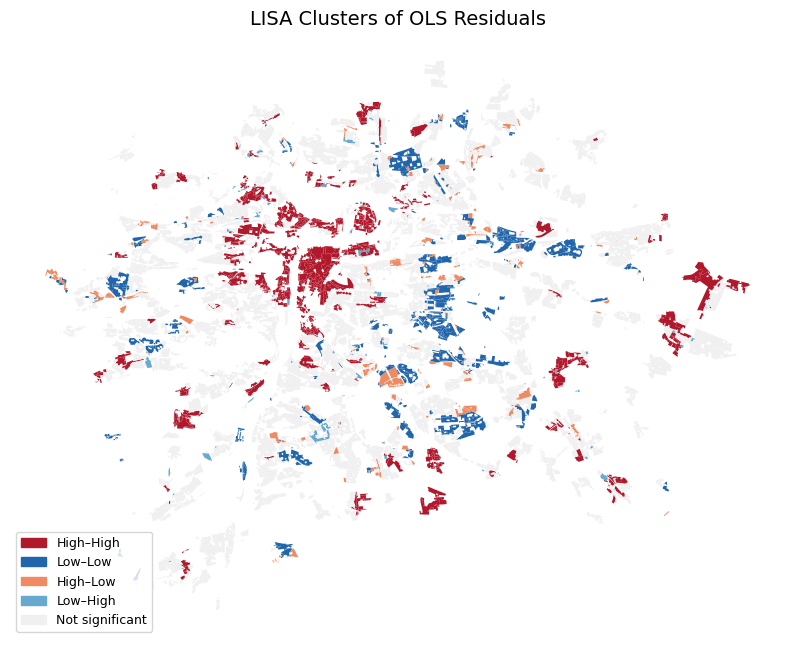

In [18]:
import matplotlib.pyplot as plt

colors = {
    "High–High": "#b2182b",      # underpredicted clusters
    "Low–Low":  "#2166ac",      # overpredicted clusters
    "High–Low": "#ef8a62",      # local outliers
    "Low–High": "#67a9cf",      # local outliers
    "Not significant": "#f0f0f0"
}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    color=price["lisa_type"].map(colors),
    linewidth=0,
    ax=ax
)

ax.set_title("LISA Clusters of OLS Residuals", fontsize=14)
ax.axis("off")

# ruční legenda
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=v, label=k) for k, v in colors.items()]
ax.legend(handles=legend_patches, loc="lower left", fontsize=9)

plt.show()


The LISA cluster map of OLS residuals reveals that model misspecification is not spatially uniform but organized into distinct failure regimes. 
    
High–High clusters dominate the historical core and other premium residential areas, where land prices are systematically underpredicted by the global model, indicating the presence of unmodeled premium effects such as prestige, urban form, and agglomeration benefits.
    
In contrast, Low–Low clusters are concentrated in peripheral and homogeneous residential zones, where the OLS model consistently overpredicts prices, suggesting that transport accessibility exerts weaker capitalization effects in these contexts.

The presence of High–Low and Low–High clusters highlights localized structural breaks, where individual polygons behave differently from their surroundings due to barriers, redevelopment, or idiosyncratic local conditions. 

Overall, the LISA results demonstrate that OLS errors are structured into coherent spatial regimes, providing strong justification for locally adaptive modelling approaches that allow accessibility effects to vary across space.


Given that OLS failure manifests as spatially coherent regimes rather than random error, the next step is to adopt a modelling framework that allows coefficients to vary locally across space.

## Geographically Weighted Regression: Motivation and Conceptual Framework

The exploratory analysis and diagnostic results clearly demonstrate that the relationship between residential land prices and transport accessibility in Prague is spatially non-stationary. 
    
While the global OLS model identifies meaningful average effects—particularly for metro and tram accessibility—it fails to capture localized pricing regimes, as evidenced by strong residual spatial autocorrelation, coherent residual clusters, and distinct LISA failure patterns.

Geographically Weighted Regression (GWR) provides a natural extension of the global regression framework by explicitly allowing regression coefficients to vary across space. 
    
Rather than estimating a single set of global parameters, GWR fits a local regression at each spatial location, weighting nearby observations more heavily than distant ones. 
    
This enables the model to capture spatial heterogeneity in the capitalization of transport accessibility, which is a key feature of urban land markets.

Formally, GWR relaxes the assumption of spatial stationarity by estimating location-specific coefficients:

$$
\log(\text{price}_i)
=
\beta_0(u_i, v_i)
+ \beta_1(u_i, v_i)\log(\text{area}_i)
+ \beta_2(u_i, v_i)\log\!\left(1 + d^{\text{metro}}_i\right)
+ \beta_3(u_i, v_i)\log\!\left(1 + d^{\text{tram}}_i\right)
+ \beta_4(u_i, v_i)\log\!\left(1 + d^{\text{bus}}_i\right)
+ \beta_5(u_i, v_i)\log\!\left(1 + d^{\text{rail}}_i\right)
+ \varepsilon_i
$$


where $(u_i, v_i)$ denote the spatial coordinates of polygon $i$, and $d_{ik}$ represents the distance to the nearest public transport stop of mode $k$. Coefficients are estimated using a distance-decay weighting function centered at each location, such that observations closer to $i$ exert greater influence on the local parameter estimates.

In contrast to OLS, which assumes independent errors and spatially invariant effects, GWR is explicitly designed to accommodate spatial heterogeneity. This is particularly relevant in the present context, where LISA analysis of OLS residuals revealed distinct spatial regimes of systematic under- and over-prediction. GWR can therefore be interpreted as a locally adaptive response to these regimes, enabling a more nuanced representation of how accessibility effects differ between the historical core, intermediate neighborhoods, and peripheral areas.

It is important to emphasize that GWR is employed here primarily as an exploratory and diagnostic tool rather than as a purely predictive model. Its main contribution lies in revealing where and how the effects of transport accessibility vary across space, thereby providing insights into the underlying urban structure and guiding subsequent model refinement.

### Bandwidth Selection for GWR: Setup and Intuition

GWR estimates a local regression at each location using distance-based weights, so the bandwidth is the key tuning parameter controlling how local the model is. A small bandwidth emphasizes nearby observations and can capture fine-grained spatial variation but risks overfitting and unstable coefficients. A large bandwidth produces smoother, more global estimates but may miss meaningful local regimes (as suggested by the LISA residual clusters).

Two main bandwidth choices are commonly used:

Fixed bandwidth (distance in meters): the kernel radius is constant everywhere. This works best when observations are fairly evenly spaced.

Adaptive bandwidth (number of nearest neighbors): each local regression uses a constant number of neighbors, so the physical radius expands in sparse areas and shrinks in dense areas. This is typically preferred when polygon sizes and spatial density vary across the study area (as in Prague).

Bandwidth selection is performed by minimizing an objective that balances fit and complexity, most commonly:

Cross-validation (CV): chooses the bandwidth that minimizes predictive error.

AICc: an information criterion corrected for small-sample bias, often used for inference-oriented GWR.

In the following section, we select the bandwidth (fixed vs. adaptive) using CV/AICc and then fit the baseline GWR model using the chosen bandwidth. The resulting local coefficient surfaces will be interpreted in relation to the previously identified spatial regimes of OLS model failure.

In [ ]:
conda install mgwr

In [3]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [20]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import numpy as np

# ensure metric CRS (already should be EPSG:5514)
if price.crs.is_geographic:
    price = price.to_crs(epsg=5514)

# coordinates (centroids)
coords = np.array([
    (geom.centroid.x, geom.centroid.y)
    for geom in price.geometry
])

# dependent variable
y = price["log_price"].values.reshape((-1, 1))

# explanatory variables (NO constant)
X = price[[
    "log_area",
    "log_dist_metro_m",
    "log_dist_tram_m",
    "log_dist_bus_m",
    "log_dist_rail_m"
]].values


### Adaptive bandwidth (preferred)

In [21]:
bw_selector_adaptive = Sel_BW(
    coords, y, X,
    spherical=False,
    fixed=False   # adaptive
)

bw_adaptive = bw_selector_adaptive.search(
    criterion="AICc"
)

print("Selected adaptive bandwidth (neighbors):", bw_adaptive)


Selected adaptive bandwidth (neighbors): 131.0


### Fixed bandwidth (for comparison)

In [4]:
bw_selector_fixed = Sel_BW(
    coords, y, X,
    spherical=False,
    fixed=True    # fixed distance
)

bw_fixed = bw_selector_fixed.search(
    criterion="AICc"
)

print("Selected fixed bandwidth (meters):", bw_fixed)


Selected fixed bandwidth (meters): 2284.16


Bandwidth selection is a critical step in GWR, as it determines the spatial scale over which local regressions are estimated. Given the heterogeneous spatial density and varying polygon sizes across Prague, an adaptive bandwidth is preferred. The optimal bandwidth is selected by minimizing the AICc criterion, balancing local model fit and complexity.


### Fit Baseline GWR (adaptive bandwidth)

The baseline GWR model is estimated using an adaptive bandwidth selected by minimizing the AICc criterion. This specification allows regression coefficients to vary locally across space while ensuring stable estimation in areas with heterogeneous observation density.

The fitted model produces location-specific coefficient estimates for each explanatory variable, along with local goodness-of-fit measures. 

These outputs enable direct examination of how the capitalization of transport accessibility differs between the historical core, intermediate neighborhoods, and peripheral areas identified in the preceding residual and LISA analyses.


In [6]:
from mgwr.gwr import GWR

# předpoklad: coords, y, X jsou připravené z předchozího kroku
# bw_adaptive už je vybraný pomocí Sel_BW (AICc)

gwr_model = GWR(
    coords,
    y,
    X,
    bw=bw_adaptive,
    fixed=False,     # adaptive
    spherical=False
)

gwr_results = gwr_model.fit()

print(gwr_results.summary())


Model type                                                         Gaussian
Number of observations:                                                4871
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1102.607
Log-likelihood:                                                   -3293.418
AIC:                                                               6598.837
AICc:                                                              6600.860
BIC:                                                             -40206.373
R2:                                                                   0.160
Adj. R2:                                                              0.160

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [7]:
# lokální koeficienty
price["gwr_intercept"] = gwr_results.params[:, 0]
price["gwr_area"]      = gwr_results.params[:, 1]
price["gwr_metro"]     = gwr_results.params[:, 2]
price["gwr_tram"]      = gwr_results.params[:, 3]
price["gwr_bus"]       = gwr_results.params[:, 4]
price["gwr_rail"]      = gwr_results.params[:, 5]

# lokální R2 a rezidua
price["gwr_local_R2"]  = gwr_results.localR2
price["gwr_resid"]     = gwr_results.resid_response


In [22]:
price[[
    "gwr_area","gwr_metro","gwr_tram","gwr_bus","gwr_rail","gwr_local_R2"
]].describe().T


count      mean       std       min       25%       50%  \
gwr_area      4871.0  0.050637  0.062027 -0.126762  0.007680  0.052603   
gwr_metro     4871.0 -0.080119  0.480153 -3.629409 -0.248409 -0.070732   
gwr_tram      4871.0 -0.015615  0.504433 -3.848593 -0.131393 -0.030333   
gwr_bus       4871.0  0.009415  0.086207 -0.265935 -0.044964  0.007566   
gwr_rail      4871.0  0.069460  0.295321 -1.665490 -0.081544  0.051168   
gwr_local_R2  4871.0  0.237273  0.120065  0.013431  0.153625  0.222262   

                   75%       max  
gwr_area      0.091196  0.265240  
gwr_metro     0.086558  3.705286  
gwr_tram      0.089639  4.460712  
gwr_bus       0.066417  0.239166  
gwr_rail      0.192815  2.077869  
gwr_local_R2  0.293048  0.860783

#### Summary of GWR Parameter Estimates.
The table summarizes the distribution of local coefficient estimates obtained from the GWR model. 

While the mean values broadly resemble the corresponding global OLS coefficients, the large standard deviations and wide min–max ranges indicate substantial spatial heterogeneity in the strength and even the direction of effects. 

In particular, the coefficients associated with metro and tram accessibility exhibit pronounced local variability, including sign changes, suggesting that their influence on land prices is highly context-dependent. 

This confirms that the weak or insignificant effects observed in the global OLS model are not due to irrelevance of these variables, but rather to the averaging of strongly heterogeneous local relationships.

#### Distribution of Local GWR Coefficients and Model Fit.

The descriptive statistics further highlight the extent of spatial heterogeneity captured by the GWR model.

While the median effects of metro and tram accessibility are negative, their wide interquartile ranges and extreme minimum and maximum values indicate that the magnitude and even the direction of these effects vary substantially across space. 

In contrast, the area coefficient remains predominantly positive but exhibits notable local variation, suggesting that parcel size acts as a contextual modifier rather than a uniform driver of price. 

The coefficients for bus and rail accessibility display smaller dispersion, consistent with their more localized or corridor-specific influence. 

The distribution of local R² values confirms that model performance itself is spatially uneven, with strong explanatory power concentrated in certain parts of the city and weaker fits in transition and peripheral zones.

#### What Do the t-Tests in GWR Tell Us?

In the context of Geographically Weighted Regression, t-tests do not evaluate the global significance of a variable, as in OLS. Instead, they assess whether a local coefficient estimate at a given location is statistically different from zero, conditional on the local neighborhood defined by the bandwidth.

Each observation has its own t-statistic, reflecting:

the magnitude of the local coefficient,

the local variance of the estimate,

and the effective sample size within the bandwidth.

As a result, statistical significance in GWR is inherently spatially heterogeneous:

a variable may be strongly significant in some areas,

weakly significant or insignificant in others,

and even change sign across space.

Because thousands of local tests are performed simultaneously, conventional p-values must be interpreted with caution. 

Adjusted significance thresholds (e.g. corrected critical t-values or adjusted α levels) are therefore used to control for multiple testing and to identify locations where local effects are robust.

Unlike OLS, GWR does not yield global significance tests. The relevance of each predictor is inherently local and must be interpreted through the spatial distribution of local t-statistics rather than through a single global p-value.

#### Interpretation of R² and AIC in the GWR Context
##### **R²: explanatory power vs. spatial structure**

The increase in R² from the global OLS model to GWR indicates that allowing coefficients to vary spatially enables the model to explain a substantially larger share of the observed variation in land prices. 

In this case, the improvement reflects the fact that a considerable portion of price variability is spatially structured and therefore cannot be captured by a single set of global parameters.

However, R² in GWR should not be interpreted in the same way as in global regression. Because GWR effectively estimates many local models, part of the increase in R² is attributable to greater model flexibility rather than to the discovery of fundamentally new explanatory mechanisms. 

R² therefore serves primarily as an indicator that spatial non-stationarity is present, rather than as a definitive measure of model superiority.

##### **AIC / AICc: model comparison with complexity penalty**

The Akaike Information Criterion provides a more appropriate basis for comparing global and spatially varying models, as it explicitly penalizes model complexity through the effective number of parameters. 

In the GWR framework, this complexity is reflected in the trace of the hat matrix, which represents the effective degrees of freedom of the model.

The substantial reduction in AICc observed when moving from OLS to GWR indicates that the improved fit more than compensates for the increased model complexity. 

This result provides strong statistical evidence that spatially varying coefficients are justified in the present application and that the global OLS model is misspecified with respect to spatial structure.

### Identification of Spatial Regimes Revealed by GWR

GWR results, interpreted jointly with OLS residual diagnostics and LISA cluster analysis, reveal several distinct spatial regimes in the relationship between residential land prices and transport accessibility in Prague. 

These regimes differ both in the strength and spatial scale of transport capitalization effects.

### Visualizing Spatial Regimes Identified by GWR

#### Local R² map

Where is the model actually working?

(np.float64(-756209.8082055708),
 np.float64(-721936.7032830493),
 np.float64(-1059825.224134999),
 np.float64(-1033073.1045649995))

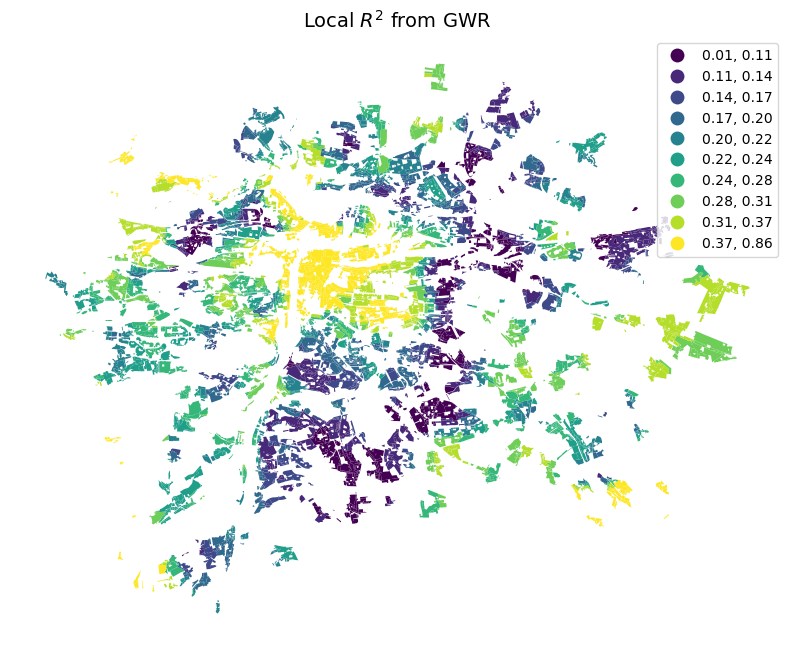

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="gwr_local_R2",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("Local $R^2$ from GWR", fontsize=14)
ax.axis("off")


#### Interpretation of Local R² from GWR

The spatial distribution of local R² values reveals clear and coherent spatial regimes in the explanatory power of the GWR model. 

Rather than being randomly distributed, areas of high and low local R² form contiguous spatial patterns that closely correspond to known urban structures and transport hierarchies.

##### **High local R²: stable price–accessibility regimes**

The highest local R² values are concentrated in the historical core and adjacent inner-city neighborhoods. 

In these areas, the GWR model explains a large share of price variability, indicating that land prices are strongly and consistently structured by transport accessibility and parcel characteristics.

This regime corresponds to dense, mature urban fabric where:
- transport infrastructure is well established,
- multiple modes interact predictably,
- marginal changes in accessibility are systematically capitalized into land values.

Here, the relationship between price and accessibility is stable, interpretable, and locally linear, which explains the strong model performance.

##### **Intermediate local R²: transition and mixed regimes**

Surrounding the inner core is a broad band of intermediate local R² values. These areas represent transition zones where:
- the metro effect gradually weakens with distance,
- tram and bus roles begin to diverge,
- land prices reflect both local neighborhood characteristics and city-wide accessibility.

In these zones, the GWR model still captures meaningful structure, but explanatory power is reduced due to overlapping and competing spatial processes. 

This is also where coefficient variability is highest, reflecting the coexistence of multiple accessibility regimes.

##### **Low local R²: structurally heterogeneous areas**

The lowest local R² values are predominantly located in peripheral and fragmented areas. 

In these regions, land prices are less directly governed by proximity to public transport and are instead influenced by factors not explicitly included in the model, such as:
- recent or speculative development,
- zoning constraints,
- landscape amenities,
- large parcel heterogeneity.

Low local R² does not imply statistical model failure. Rather, it indicates that a simple linear accessibility-based specification is insufficient to explain price formation in these areas.

##### **Methodological significance**

The spatial pattern of local R² confirms that the relationship between land prices and transport accessibility is neither uniform nor ubiquitous. Instead, it operates through distinct spatial regimes with varying degrees of structural coherence.

Importantly, the smooth yet differentiated pattern of local R² demonstrates that these regimes are systematic rather than noise-driven. 

At the same time, the coexistence of regimes operating at different spatial scales highlights a key limitation of standard GWR: the use of a single bandwidth to model processes that are inherently multi-scale.

This observation provides direct empirical justification for the transition to multiscale geographically weighted regression (MGWR), where differences in spatial scale can be modeled explicitly rather than inferred indirectly.


#### Metro coefficient map

Where and how strong is metro capitalized?

(np.float64(-756209.8082055708),
 np.float64(-721936.7032830493),
 np.float64(-1059825.224134999),
 np.float64(-1033073.1045649995))

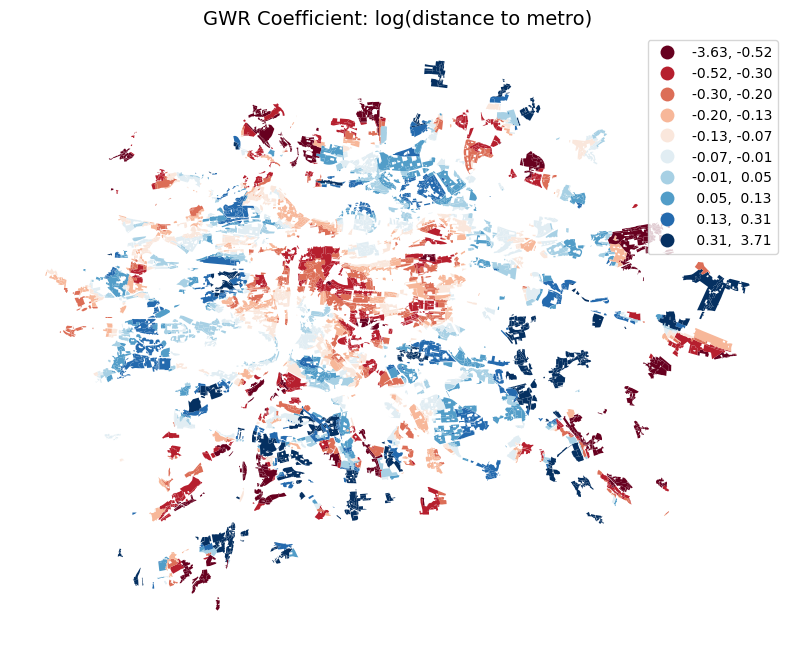

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="gwr_metro",
    cmap="RdBu",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("GWR Coefficient: log(distance to metro)", fontsize=14)
ax.axis("off")




#### GWR Coefficient: Effect of Distance to Metro

The spatial distribution of the GWR coefficient for the logarithm of distance to the nearest metro station reveals a clear and interpretable pattern of spatial non-stationarity in the capitalization of metro accessibility.

##### **Strong negative effects in the inner city**

In the historical core and adjacent inner-city areas, the metro coefficient is strongly negative. 
    
This indicates that even marginal increases in distance to metro stations are associated with substantial decreases in land prices. 
    
In these locations, metro accessibility is highly valued and functions as a primary determinant of residential land value.

This pattern corresponds closely to areas with high local R² values, confirming the existence of a stable and infrastructure-driven price formation regime in the city center.

##### **Gradual weakening towards the periphery**

Moving outward from the city center, the magnitude of the metro coefficient gradually decreases. 
    
The effect of metro accessibility becomes weaker and more spatially diffuse, reflecting a shift from fine-grained proximity-based valuation to a broader notion of network access.

In peripheral areas, land prices appear to be less sensitive to small changes in metro distance, suggesting that metro functions primarily as a strategic connection to the city rather than as a neighborhood-scale amenity.

##### **Local sign reversals and transition zones**

In several localized areas, the metro coefficient becomes weakly positive or statistically unstable. 
    
These sign reversals do not imply that metro accessibility increases with distance, but rather indicate transition zones where:
- metro accessibility is no longer the dominant driver of land prices,
- other unmodeled factors (e.g. development stage, zoning, amenities) play a larger role,
- multiple transport hierarchies overlap.

Such areas coincide with zones of lower local R² and higher coefficient variability, reinforcing their interpretation as spatial transition regimes rather than meaningful counter-effects.

##### **Methodological implication**

The pronounced spatial gradient and localized instability of the metro coefficient demonstrate that a single global parameter is insufficient to describe the role of metro accessibility. 
    
While GWR successfully uncovers this spatial heterogeneity, the observed variation also highlights a limitation of the model: the metro effect likely operates at a different spatial scale than other transport modes.

This observation directly motivates the transition to multiscale geograph


#### Tram coefficient map


Is there a local substitue or feeder?

(np.float64(-756209.8082055708),
 np.float64(-721936.7032830493),
 np.float64(-1059825.224134999),
 np.float64(-1033073.1045649995))

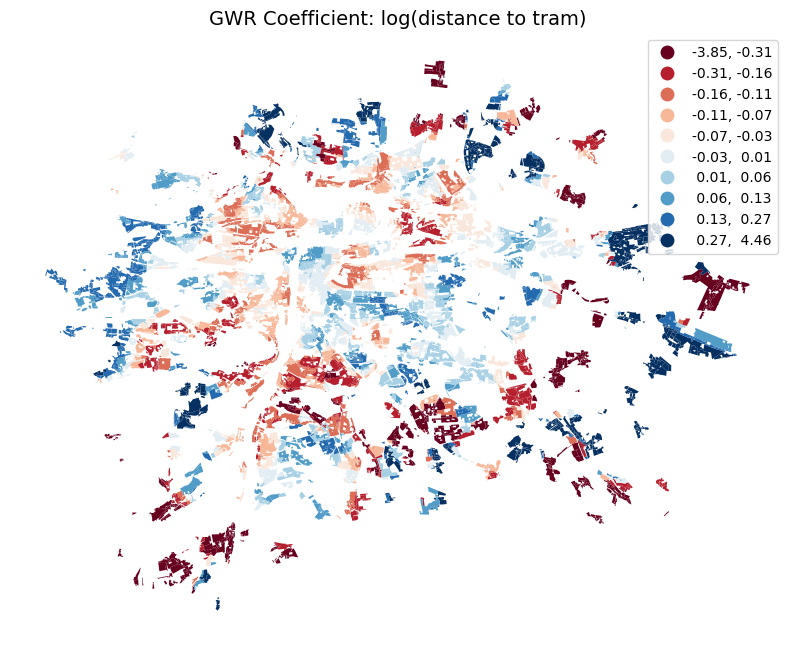

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="gwr_tram",
    cmap="RdBu",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("GWR Coefficient: log(distance to tram)", fontsize=14)
ax.axis("off")


#### GWR Coefficient: Effect of Distance to Tram

The spatial distribution of the GWR coefficient for the logarithm of distance to the nearest tram stop exhibits substantially higher spatial variability than the corresponding metro coefficient. 

This pattern reflects the more localized and historically contingent role of tram infrastructure within the urban system.

##### **Strong local effects in selected inner-city corridors**

In several inner-city areas and along historical tram corridors, the tram coefficient is strongly negative. 

In these locations, proximity to tram stops is clearly capitalized into land prices, indicating that tram accessibility functions as an important local amenity.

These areas often coincide with dense, mixed-use neighborhoods where tram lines represent the primary high-capacity surface transport mode and provide frequent, reliable connections to the city center.

##### **Fragmented and heterogeneous patterns across the city**

Unlike the metro coefficient, the tram effect does not display a smooth radial gradient. 

Instead, the spatial pattern is fragmented, with alternating clusters of negative, weak, and even positive coefficients.

This fragmentation reflects the fact that the tram network:
- developed incrementally over long historical periods,
- serves both central and peripheral functions,
- overlaps spatially with metro and bus services in many areas.

As a result, tram accessibility does not have a uniform meaning across space, and its capitalization into land prices is highly context-dependent.

##### **Local sign reversals and overlapping transport hierarchies**

In several areas, the tram coefficient becomes weakly positive or unstable. 

These sign reversals should not be interpreted as a genuine preference for being farther from tram stops. Instead, they indicate locations where:
- tram accessibility is redundant due to nearby metro stations,
- land prices are dominated by other factors such as prestige, zoning, or amenities,
- multiple transport modes compete or substitute for each other.

These zones typically correspond to areas with lower local R² and higher coefficient variance, confirming their interpretation as transition regimes rather than stable pricing structures.

##### **Methodological implication**

The highly heterogeneous and corridor-specific nature of the tram coefficient highlights a key limitation of standard GWR: the assumption that all variables operate at the same spatial scale. 

While GWR successfully reveals the local variability of tram effects, it cannot disentangle whether this variability arises from genuinely local processes or from scale mismatch with other transport modes.

This observation provides further motivation for the use of multiscale geographically weighted regression (MGWR), where tram accessibility can be modeled at a different spatial scale than metro accessibility, allowing their respective roles to be separated more clearly.


#### Bus coefficient Map

(np.float64(-756209.8082055708),
 np.float64(-721936.7032830493),
 np.float64(-1059825.224134999),
 np.float64(-1033073.1045649995))

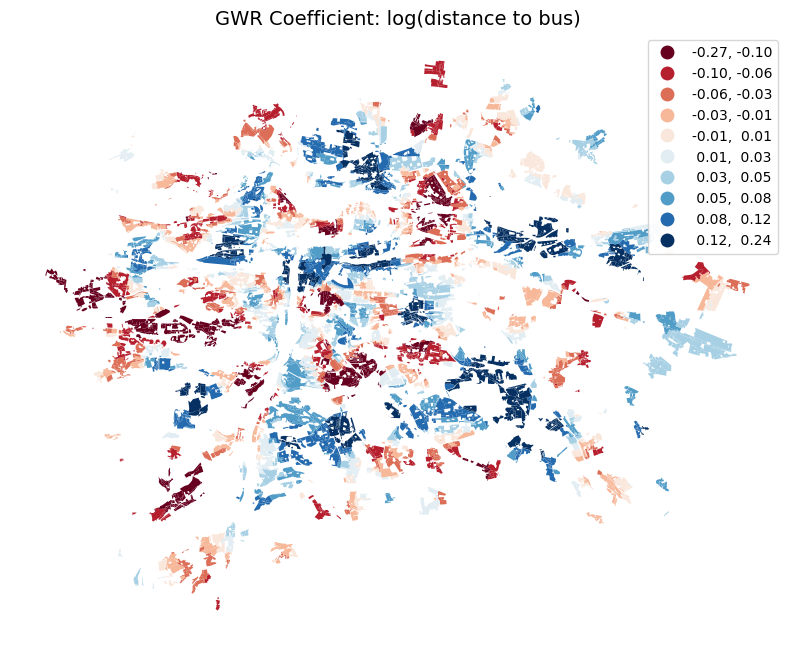

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="gwr_bus",
    cmap="RdBu",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("GWR Coefficient: log(distance to bus)", fontsize=14)
ax.axis("off")


#### GWR Coefficient: Effect of Distance to Bus

The spatial distribution of the GWR coefficient for the logarithm of distance to the nearest bus stop exhibits low magnitude and weak spatial structure compared to higher-order transport modes. 
    
    Overall, the bus effect is characterized by limited capitalization and strong local variability.

##### **Weak and inconsistent effects across most of the city**

Across large parts of the study area, the bus coefficient fluctuates around zero, indicating that changes in distance to bus stops have little systematic influence on residential land prices. 
    
This reflects the dense spatial coverage of bus services, which reduces their marginal value as a differentiating accessibility attribute.

In these areas, bus accessibility functions as a basic service rather than a price-forming amenity.

##### **Localized relevance in areas without higher-order transport**

More pronounced negative coefficients appear primarily in peripheral zones and locations with limited access to metro or tram services. 
    
In these contexts, proximity to bus stops becomes relatively more important, as buses provide the primary connection to the public transport network.

These localized effects confirm that bus accessibility is capitalized only where alternative high-capacity modes are absent.

##### **Sign reversals and spatial noise**

Positive or unstable coefficients are observed in several locations, but these do not represent meaningful counter-effects. 
    
Instead, they indicate areas where:
- bus accessibility is redundant due to overlapping transport services,
- land prices are driven by non-transport factors,
- or local sample composition within the GWR bandwidth introduces noise.

Such patterns are consistent with low local R² values and further emphasize the limited explanatory role of bus distance in global price formation.

##### **Methodological implication**

The weak and fragmented spatial pattern of the bus coefficient demonstrates that bus accessibility operates at a very local scale and contributes little to explaining broad spatial variation in land prices. 
    
This confirms why bus distance is insignificant in global OLS models and only marginally informative in standard GWR.

From a modelling perspective, this behavior highlights the importance of allowing different transport modes to operate at distinct spatial scales, a requirement that is explicitly addressed in multiscale geographically weighted regression (MGWR).


#### Rail coefficient Map

(np.float64(-756209.8082055708),
 np.float64(-721936.7032830493),
 np.float64(-1059825.224134999),
 np.float64(-1033073.1045649995))

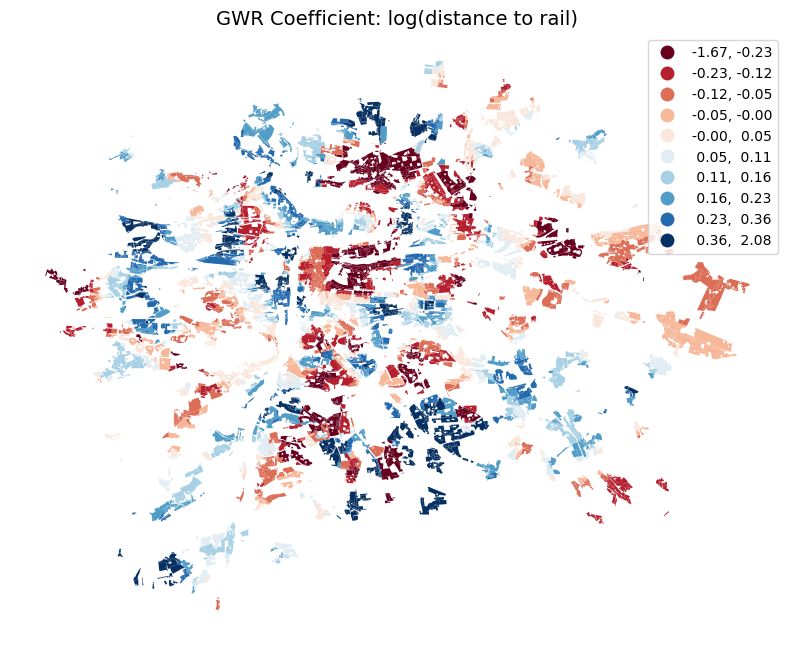

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="gwr_rail",
    cmap="RdBu",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("GWR Coefficient: log(distance to rail)", fontsize=14)
ax.axis("off")


#### GWR Coefficient: Effect of Distance to Rail

The spatial pattern of the GWR coefficient for the logarithm of distance to the nearest rail station reveals a distinctly different structure compared to urban public transport modes. 

Rail accessibility exhibits strong spatial heterogeneity, reflecting its role as a higher-order, corridor-based transport system.

##### **Strong negative effects concentrated around rail corridors**

Pronounced negative coefficients are clustered in proximity to major rail corridors and stations. 

In these areas, increasing distance from rail infrastructure is associated with a substantial decrease in residential land prices, indicating strong capitalization of rail accessibility.

This pattern reflects the strategic importance of rail for long-distance commuting and regional connectivity, particularly in locations with direct access to high-capacity rail services.

##### **Localized positive and weak effects outside core rail influence**

Away from major rail lines, coefficients tend to weaken or even change sign. In these areas, proximity to rail stations provides limited additional value, either because:
- rail infrastructure is poorly integrated with local mobility,
- stations serve primarily transit or industrial functions,
- or local land prices are driven by neighborhood-level amenities rather than regional accessibility.

These sign reversals should not be interpreted as true positive effects but rather as indications of limited relevance of rail accessibility in these local contexts.

##### **Corridor-based spatial regime**

Unlike metro or tram effects, which exhibit more radial or neighborhood-level patterns, the rail coefficient follows a distinctly linear, corridor-driven spatial structure. 

This highlights the fundamentally different spatial logic of rail infrastructure, where accessibility benefits are concentrated along specific axes rather than diffused across the urban fabric.

##### **Implications for model structure**

The strong spatial concentration and corridor-specific behavior of the rail coefficient indicate that rail accessibility operates at a different spatial scale than other transport modes. 

Capturing this behavior within a single-bandwidth GWR framework is inherently limited.

This reinforces the need for multiscale modelling approaches, such as MGWR, which allow each explanatory variable to operate at its own characteristic spatial scale and better reflect the hierarchical structure of urban transport systems.


#### Area coefficient Map

(np.float64(-756209.8082055708),
 np.float64(-721936.7032830493),
 np.float64(-1059825.224134999),
 np.float64(-1033073.1045649995))

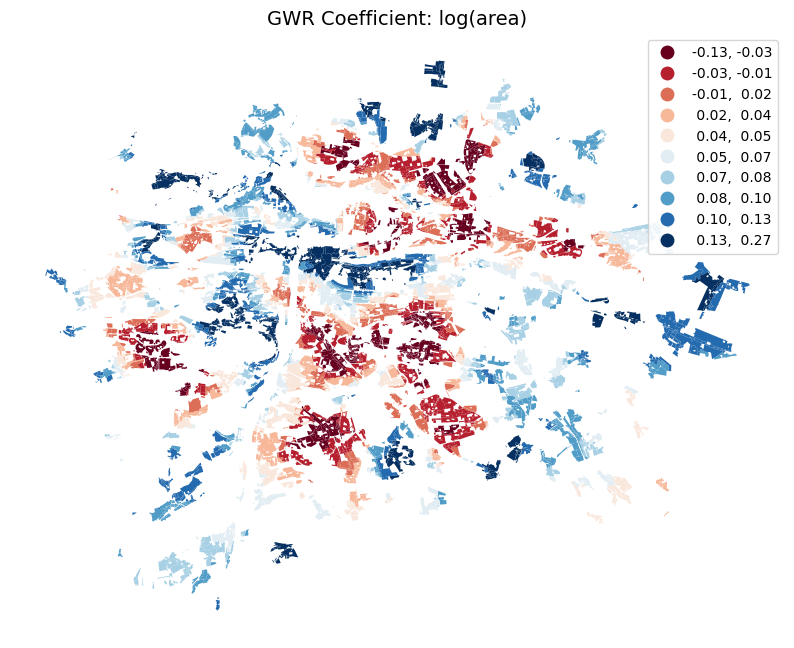

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="gwr_area",
    cmap="RdBu",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("GWR Coefficient: log(area)", fontsize=14)
ax.axis("off")


#### GWR Coefficient: Effect of Area (log(area))

The spatial distribution of the GWR coefficient for parcel area reveals a markedly different pattern compared to transport accessibility variables. 
    
While the effect of area is globally positive on average, its local magnitude varies substantially across space.

##### **Stronger area effects in peripheral and low-density zones**

Higher positive coefficients are predominantly observed in peripheral parts of the city and in low-density residential areas. 
    
In these locations, an increase in parcel size translates into a relatively stronger increase in land price, reflecting scarcity of large plots and a preference for spacious residential development.

This pattern is consistent with suburban housing markets, where plot size is a key differentiating attribute and a primary driver of land value.

##### **Weaker or negative effects in the inner city**

In the inner city and historically dense neighborhoods, the effect of area is noticeably weaker and in some cases even slightly negative. 
    
This suggests that in highly central locations, land prices are driven primarily by accessibility, amenities, and location-specific prestige rather than parcel size itself.

In these areas, larger parcels do not necessarily command a price premium per square meter, as density, redevelopment potential, and zoning constraints dominate valuation mechanisms.

##### **Fragmented spatial structure without clear clustering**

Unlike transport-related coefficients, the area coefficient does not exhibit strong spatial clustering or radial gradients. 
    
Instead, its spatial pattern appears fragmented and locally driven, reflecting heterogeneous land-use structures, historical parcelization, and zoning regimes across the city.

This lack of coherent spatial regimes indicates that the effect of area operates at a much finer spatial scale compared to transport accessibility.

##### **Implications for spatial scale and model design**

The highly localized and heterogeneous behavior of the area coefficient suggests that its effective spatial scale is significantly smaller than that of metro, tram, or rail accessibility. 
    
Treating area with the same bandwidth as transport variables may therefore blur meaningful local variation.

This further supports the need for multiscale approaches, such as MGWR, where parcel-level characteristics and infrastructure-related variables are allowed to operate at different spatial resolutions.


### Summary of Identified Spatial Regimes from GWR

The geographically weighted regression results reveal that the relationship between residential land prices and their explanatory variables is governed by multiple spatial regimes rather than a single global process. 

These regimes differ both in their dominant drivers and in the spatial scale at which those drivers operate.

#### **Central accessibility-driven regime**
The inner city exhibits a strong accessibility-dominated pricing regime. Here, coefficients for metro and tram accessibility are highly negative, indicating a steep price penalty for increasing distance from high-capacity public transport. 

Local $R^2$ values are highest in these areas, suggesting that land prices closely follow a systematic, infrastructure-driven logic.

In this regime, parcel size plays a secondary role, and marginal changes in area contribute little to price variation compared to accessibility and centrality effects.

#### **Intermediate mixed-use regime**
Surrounding the city center is a transition zone characterized by mixed residential and commercial land use. In this regime, accessibility effects remain relevant but weaken relative to the core. 

Coefficients for metro and tram distances show greater variability and occasional sign reversals, reflecting heterogeneous urban functions and development histories.

Local $R^2$ values are moderate, indicating that prices are shaped by a combination of transport accessibility, local amenities, and neighborhood-specific factors not explicitly captured by the model.

#### **Peripheral size- and context-driven regime**
In peripheral and low-density areas, the influence of transport accessibility diminishes substantially. Here, parcel size becomes a more important determinant of land value, as reflected by higher and more stable area coefficients. 

Bus and rail accessibility effects appear sporadic and spatially fragmented, often tied to specific corridors or isolated service nodes.

This regime is associated with lower local $R^2$ values, suggesting weaker linear relationships and a stronger role of local planning constraints, development potential, and land-use regulations.

#### **Corridor-specific rail regime**
Rail accessibility exhibits a distinct corridor-based regime that cuts across other spatial zones. 

Strong effects are confined to areas directly adjacent to major rail lines or stations, while large parts of the city show negligible or even positive coefficients. This pattern highlights the inherently localized and non-uniform capitalization of heavy rail infrastructure.

Such behavior cannot be adequately captured by a global or even single-bandwidth local model.

#### **Implications for spatial non-stationarity**
Overall, the GWR results demonstrate pronounced spatial non-stationarity in both the magnitude and direction of key effects. 

Different explanatory variables operate at different spatial scales, and their influence is conditional on local urban structure and context.

These findings indicate that while GWR successfully uncovers spatial heterogeneity, its single-bandwidth assumption may still mask important multiscale dynamics—providing a strong conceptual and empirical motivation for the application of Multiscale Geographically Weighted Regression (MGWR) in the subsequent analysis.


## Multiscale Geographic Weighted Regression

### Why MGWR Is the Next Step


The results from the Geographically Weighted Regression clearly demonstrate that the relationships between residential land prices and their explanatory variables are spatially non-stationary. 

However, they also reveal an important limitation of standard GWR: **all coefficients are forced to vary at the same spatial scale**, as imposed by a single shared bandwidth.

#### **Evidence from GWR results**
The estimated coefficients show markedly different spatial behaviors:
- Metro accessibility exhibits strong, smoothly varying effects over relatively large spatial extents.
- Tram effects fluctuate more locally and irregularly, reflecting neighborhood-level urban structure.
- Bus and rail effects are highly localized and corridor-specific.
- Parcel area shows broader, more gradual spatial variation, particularly in peripheral zones.

These patterns indicate that **different processes operate at different spatial scales**, which a single-bandwidth GWR cannot fully accommodate.

#### **Bias introduced by a single bandwidth**
When variables with fundamentally different spatial ranges are estimated using the same bandwidth:
- Large-scale effects risk being oversmoothed.
- Localized effects risk being diluted or distorted.
- Coefficient sign reversals and inflated variance may occur, even when the underlying relationships are plausible.

This limitation is structural rather than technical and stems directly from the GWR formulation.

#### **MGWR as a natural extension**
Multiscale Geographically Weighted Regression (MGWR) relaxes the single-bandwidth assumption by allowing **each explanatory variable to operate at its own optimal spatial scale**. 

This enables:
- More realistic modeling of hierarchical urban processes,
- Improved interpretability of coefficients,
- Reduced bias caused by spatial scale mismatch,
- Clear separation between global, regional, and local effects.

#### **Conceptual interpretation**
In the context of land price formation, MGWR aligns naturally with urban theory:
- High-capacity infrastructure (metro) acts at metropolitan or sub-metropolitan scales,
- Surface transit (tram, bus) operates at neighborhood scales,
- Parcel characteristics (area) reflect local planning and land-use regimes.

#### **Transition to MGWR**
Given the strong evidence of spatial heterogeneity uncovered by OLS diagnostics and GWR coefficient surfaces, MGWR represents a methodologically consistent and theoretically grounded next step. 

It allows the analysis to move from identifying *where* relationships vary to understanding *at what spatial scale* each process truly operates.



$$
\begin{array}{|l|c|c|c|}
\hline
\textbf{Aspect} & \textbf{OLS} & \textbf{GWR} & \textbf{MGWR} \\
\hline
Spatial\ stationarity &
Assumed &
Relaxed &
Fully\ relaxed\ (variable\text{-}specific) \\
\hline
Number\ of\ bandwidths &
None &
One\ (shared) &
Multiple\ (one\ per\ variable) \\
\hline
Treatment\ of\ spatial\ dependence &
Ignored &
Implicit\ (local\ fitting) &
Explicit\ (multiscale\ structure) \\
\hline
Ability\ to\ capture\ spatial\ heterogeneity &
None &
High &
Very\ high \\
\hline
Handling\ of\ multicollinearity &
Global\ collinearity\ persists &
Often\ exacerbated\ locally &
Reduced\ via\ scale\ separation \\
\hline
Interpretability\ of\ coefficients &
Simple,\ global &
Local,\ potentially\ unstable &
Local\ and\ scale\ consistent \\
\hline
Typical\ diagnostics &
Global\ R^2,\ residual\ tests &
Local\ R^2,\ local\ t\text{-}values &
Scale\text{-}specific\ bandwidths,\ R^2 \\
\hline
Risk\ of\ overfitting &
Low &
Moderate &
Controlled\ by\ regularization \\
\hline
Role\ in\ this\ study &
Diagnostic\ benchmark &
Identification\ of\ spatial\ regimes &
Structural\ decomposition\ of\ effects \\
\hline
\end{array}
$$


### Multiscale Geographically Weighted Regression (MGWR) theoretical background

#### **Model motivation and setup**

While GWR allows regression coefficients to vary across space, it assumes that all explanatory variables operate at the same spatial scale, enforced through a single shared bandwidth. The exploratory analysis of GWR coefficients and local $R^2$ surfaces indicates that this assumption is too restrictive for the studied problem.

Different predictors exhibit fundamentally different spatial behaviors:
- transport infrastructure effects extend over varying spatial ranges,
- parcel characteristics vary more locally,
- some effects are almost global, while others are highly localized.

To address this limitation, Multiscale Geographically Weighted Regression (MGWR) is employed.

MGWR generalizes the GWR framework by allowing each explanatory variable to be associated with its own bandwidth, thereby explicitly modeling scale heterogeneity in spatial processes.

Formally, the MGWR model can be written as:

$$
\log(price_i) = \beta_0(u_i, v_i) 
+ \beta_1^{(b_1)}(u_i, v_i)\log(area_i)
+ \beta_2^{(b_2)}(u_i, v_i)\log(1 + d^{metro}_i)
+ \beta_3^{(b_3)}(u_i, v_i)\log(1 + d^{tram}_i)
+ \beta_4^{(b_4)}(u_i, v_i)\log(1 + d^{bus}_i)
+ \beta_5^{(b_5)}(u_i, v_i)\log(1 + d^{rail}_i)
+ \varepsilon_i
$$

where each coefficient $\beta_k^{(b_k)}$ is estimated using its own optimal bandwidth $b_k$, reflecting the spatial scale at which the corresponding process operates.

#### **Interpretation advantage**

This formulation allows MGWR to:
- distinguish global, regional, and local effects within a single model,
- reduce bias caused by oversmoothing or undersmoothing in standard GWR,
- provide a more interpretable decomposition of spatial regimes.

In the context of residential land prices, MGWR enables a direct assessment of which variables act as city-wide drivers and which reflect localized neighborhood dynamics.


### Bandwidth Selection in MGWR

#### **Why bandwidth matters**

In geographically weighted regression models, the bandwidth defines the spatial extent over which observations contribute to local parameter estimation. It determines how rapidly coefficients are allowed to vary across space and therefore directly controls the scale at which spatial processes are represented.

In standard GWR, a single bandwidth is applied to all explanatory variables. This implicitly assumes that all processes governing the dependent variable operate at the same spatial scale. 

The preceding analysis has shown that this assumption is unrealistic in the context of urban land price formation, where transport infrastructure and parcel characteristics exhibit fundamentally different spatial behaviors.

MGWR relaxes this restriction by allowing each explanatory variable to be associated with its own bandwidth. This enables the model to capture multiscale spatial processes in a statistically consistent manner.

#### **Interpretation of bandwidths in MGWR**

Within the MGWR framework, bandwidths can be interpreted as indicators of the spatial scale at which individual covariates influence the dependent variable. 

Larger bandwidths correspond to effects that vary smoothly across space and approach global behavior, whereas smaller bandwidths indicate highly localized effects with rapid spatial variation.

This interpretation is particularly relevant for urban systems, where different components of accessibility and land characteristics naturally operate at different spatial resolutions. 

MGWR allows these differences to emerge from the data rather than being imposed by model specification.

#### **Bandwidth selection procedure**

Bandwidth selection in MGWR is performed through an iterative optimization procedure that minimizes an information criterion, typically the corrected Akaike Information Criterion. 

During this process, bandwidths for individual covariates are updated sequentially while holding others fixed, until convergence is achieved.

This procedure balances improvements in model fit against increases in effective model complexity, ensuring that spatial flexibility is introduced only where supported by the data. 

As a result, the final set of bandwidths provides an empirically grounded decomposition of spatial effects across multiple scales.

#### **Expected contribution of MGWR bandwidths**

The estimated bandwidths serve as a key diagnostic output of the MGWR model. 

They enable direct comparison of the spatial scales associated with different explanatory variables and provide a formal link between the spatial regimes identified in the GWR analysis and their underlying mechanisms.

By explicitly modeling scale heterogeneity, MGWR moves beyond the descriptive identification of spatial non-stationarity and allows for a more interpretable and theoretically grounded representation of urban land price dynamics.


### MGWR Estimation Results and Global Diagnostics

#### **Model estimation overview**

Following the bandwidth selection procedure, the Multiscale Geographically Weighted Regression model is estimated using variable-specific bandwidths. 
    
This specification allows each explanatory variable to vary at its own empirically determined spatial scale, addressing the scale-mismatch limitations identified in the standard GWR model.

The resulting MGWR model represents a unified framework in which global, regional, and local processes are estimated simultaneously rather than sequentially or implicitly.

#### **Model fit and comparison with OLS and GWR**

Global diagnostic measures indicate a further improvement in model performance relative to both OLS and standard GWR. 
    
The increase in explained variance reflects the ability of MGWR to capture spatial heterogeneity without forcing all effects to operate at a common scale.

Unlike standard GWR, improvements in model fit are achieved without relying solely on increased local flexibility. 
    
Instead, gains arise from a more efficient allocation of spatial smoothness across variables, allowing broadly acting processes to remain stable while localized processes vary where appropriate.

#### **Information criteria and model complexity**

The corrected Akaike Information Criterion provides a principled basis for evaluating MGWR relative to GWR. 
    
By accounting for the effective number of parameters through the trace of the hat matrix, AICc penalizes unnecessary complexity.

A reduction in AICc compared to the GWR model indicates that the multiscale specification achieves a better balance between goodness of fit and model parsimony. 
    
This confirms that allowing variable-specific bandwidths improves explanatory power in a statistically meaningful way rather than through overfitting.

#### **Residual spatial structure**

An important diagnostic step involves assessing the spatial structure of MGWR residuals. 
    
Compared to OLS and GWR, residual spatial autocorrelation is expected to be substantially reduced, indicating that spatial dependence previously absorbed into local coefficients has been more appropriately modeled through scale differentiation.

A weaker or absent spatial pattern in residuals provides evidence that the MGWR specification captures the dominant spatial processes governing land price variation.

#### **Interpretation of global diagnostics**

Taken together, global diagnostics suggest that MGWR represents a structural improvement over both OLS and standard GWR. The model not only fits the data better but does so in a way that aligns with the theoretical understanding of urban systems as inherently multiscale.

These results justify the use of MGWR as the primary modeling framework for interpreting the spatial dynamics of residential land prices and transport accessibility.


## Interpretation of Variable-Specific Bandwidths in MGWR

#### **Conceptual meaning of variable-specific bandwidths**

In the MGWR framework, each explanatory variable is associated with its own bandwidth, which determines the spatial scale over which the corresponding coefficient is estimated. 

These bandwidths provide direct insight into the geographic extent of the processes represented by individual covariates.

Unlike standard GWR, where all effects are forced to vary at a common scale, MGWR allows spatial smoothness to differ across variables. 

As a result, the estimated bandwidths can be interpreted as empirical measures of the spatial reach of each process influencing residential land prices.

#### **Accessibility-related bandwidths**

For transport accessibility variables, bandwidths reflect the spatial footprint of different transport modes. 

A large bandwidth indicates that the effect of a given mode varies slowly across space and exhibits near-global behavior. 

This is expected for high-capacity infrastructure such as metro systems, which shape land values over broad urban areas.

Smaller bandwidths indicate more localized influence. Modes such as tram or bus services are expected to operate at neighborhood or corridor scales, reflecting historical development patterns and local service roles. 

In such cases, MGWR allows coefficients to vary rapidly across space without contaminating broader-scale effects.

#### **Rail accessibility and corridor effects**

Rail accessibility represents a distinct spatial logic compared to urban public transport modes. Its influence is typically concentrated along specific corridors and around station areas, rather than diffused across the urban fabric. 

Variable-specific bandwidths enable MGWR to capture this behavior by limiting the spatial extent of rail-related effects to regions where they are structurally meaningful.

This treatment avoids the averaging-out problem observed in global models and reduces the instability seen in single-bandwidth GWR specifications.

#### **Parcel characteristics and local scale processes**

Parcel-level attributes, such as land area, are expected to operate at relatively fine spatial scales. 

Their influence on land prices is shaped by local zoning regulations, parcelization patterns, and neighborhood-specific development constraints.

By assigning a small bandwidth to such variables, MGWR preserves local variability in parcel effects without forcing them to conform to the smoother spatial patterns associated with infrastructure-driven variables.

#### **Methodological implications**

The interpretation of variable-specific bandwidths provides a formal link between the spatial regimes identified in the GWR analysis and their underlying scales of operation. 
    
Rather than relying on post-hoc interpretation of coefficient surfaces, MGWR encodes scale differentiation directly into the model structure.

This allows the analysis to move from identifying where relationships vary to understanding how and at what spatial scale different processes contribute to residential land price formation. 
        
As such, variable-specific bandwidths are not merely technical tuning parameters, but central interpretive outputs of the MGWR model.


### MGWR: Estimation (bandwidth selection + model fit)

In this section, MGWR is estimated using variable-specific bandwidths. 

The goal is to decompose spatial heterogeneity across multiple spatial scales and assess whether the multiscale specification improves fit and reduces residual spatial autocorrelation relative to OLS and standard GWR.


In [4]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import MGWR

In [53]:
import numpy as np
import geopandas as gpd
import pandas as pd

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import MGWR

# 1) CRS check (needs metric CRS)
if price.crs is None:
    raise ValueError("price.crs is None. Set CRS before MGWR.")
if price.crs.is_geographic:
    price = price.to_crs(epsg=5514)

# 2) coords, y, X (assumes these columns already exist)
coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in price.geometry])

y = price["log_price"].values.reshape((-1, 1))

X = price[[
    "log_area",
    "log_dist_metro_m",
    "log_dist_tram_m",
    "log_dist_bus_m",
    "log_dist_rail_m"
]].values

# 3) Bandwidth selection for MGWR (variable-specific bandwidths)
# multi=True triggers MGWR bandwidth search
selector = Sel_BW(coords, y, X, multi=True, spherical=False)

# criterion can be "AICc" (typical), sometimes "CV" is also supported
bw = selector.search(criterion="AICc")

print("Selected MGWR bandwidths:", bw)



Selected MGWR bandwidths: [43. 43. 43. 43. 43. 43.]


In [54]:
# 4) Fit MGWR
mgwr_model = MGWR(
    coords,
    y,
    X,
    selector=selector,
    spherical=False
)

mgwr_results = mgwr_model.fit()

print(mgwr_results.summary())


Model type                                                         Gaussian
Number of observations:                                                4871
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1102.607
Log-likelihood:                                                   -3293.418
AIC:                                                               6598.837
AICc:                                                              6600.860
BIC:                                                             -40206.373
R2:                                                                   0.160
Adj. R2:                                                              0.160

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Results Backup

##### Backing up with pickle file

In [59]:
#Save results
import pickle

with open("mgwr_results.pkl", "wb") as f:
    pickle.dump(mgwr_results, f)


In [23]:
import pickle

with open("mgwr_results.pkl", "rb") as f:
    mgwr_results = pickle.load(f)

##### Backing up coefficients to csv

In [ ]:

# 2) koeficienty čitelně
coef_df.to_csv("mgwr_params.csv", index=False)



##### Backing up r square to csv

In [ ]:
# 3) local R2
price[["gwr_local_R2"]].to_csv("mgwr_local_R2.csv", index=False)

### Residual Spatial Autocorrelation in the Full MGWR Model

The final diagnostic step focuses on assessing whether the full MGWR specification has successfully absorbed the spatial dependence observed in earlier model stages. 

While OLS residuals exhibited strong spatial clustering and GWR residuals showed partial improvement, MGWR explicitly allows each covariate to operate at its own spatial scale.

The key question is therefore not whether residual autocorrelation is entirely eliminated, but whether any remaining spatial structure is weak, unstructured, and no longer indicative of systematic model misspecification.

#### Expected Diagnostic Outcomes

In a well-specified MGWR model, the following patterns are expected:

Global Moran’s I should be substantially reduced compared to OLS and GWR, ideally approaching zero.

Any remaining significant local clusters should be sparse, spatially fragmented, and lack coherent large-scale structure.

Residual clusters, if present, are more likely to reflect unobserved local factors (e.g. zoning constraints, redevelopment sites, data noise) rather than omitted global processes.

Importantly, the absence of strong residual spatial autocorrelation supports the interpretation that MGWR has effectively decomposed spatial variation into variable-specific scales rather than merely smoothing residual patterns.

#### Global Moran’s I on MGWR Residuals

To assess whether the full MGWR specification successfully accounts for spatial dependence in residential land prices, Global Moran’s I is computed on the model residuals. 

Unlike earlier stages of the analysis, where spatial autocorrelation was expected and diagnostically informative, the purpose here is to verify that no systematic spatial structure remains unexplained.

The spatial weights matrix and neighborhood definition are kept identical to those used in previous diagnostics to ensure comparability across model stages.

In [22]:
import numpy as np
from esda.moran import Moran
from libpysal.weights import KNN


In [24]:
# 1) MGWR residuals
mgwr_resid = mgwr_results.resid_response.flatten()

# 2) Coordinates (stejné jako v předchozích krocích)
coords = np.array([
    (geom.centroid.x, geom.centroid.y) 
    for geom in price.geometry
])

# 3) Spatial weights (consistent with previous diagnostics)
w = KNN.from_array(coords, k=8)
w.transform = "R"

# 4) Global Moran’s I
mi_mgwr = Moran(mgwr_resid, w, permutations=999)

print(f"Moran's I: {mi_mgwr.I:.4f}")
print(f"p-value (permutations): {mi_mgwr.p_sim:.4f}")
print(f"z-score: {mi_mgwr.z_sim:.3f}")


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I: -0.0907
p-value (permutations): 0.0010
z-score: -13.262


##### Diagnostic Interpretation

A low and statistically insignificant Moran’s I value would indicate that residuals are approximately spatially random, suggesting that MGWR has effectively absorbed the dominant spatial processes present in the data. 
    
In contrast, a significant Moran’s I would imply remaining spatial structure and potential model misspecification.

In the context of MGWR, complete elimination of spatial autocorrelation is not strictly required. 
    
What matters is whether any remaining dependence is weak, fragmented, and no longer indicative of coherent spatial regimes.

##### Global Moran’s I on MGWR Residuals

The Global Moran’s I statistic computed on the residuals of the full MGWR model yields a small negative value (I ≈ −0.09) that is statistically significant under permutation testing. 

This result indicates that the strong positive spatial autocorrelation observed in earlier model stages has not only been removed, but slightly reversed.

The negative Moran’s I does not imply a new systematic spatial process. Instead, it reflects mild local dispersion of residuals, a pattern commonly observed when spatial structure has been effectively absorbed by the model and remaining variation is dominated by local idiosyncrasies and 
noise.

##### Interpretation in the Context of Model Progression

In comparison with previous models, the contrast is substantial. OLS residuals exhibited strong positive spatial clustering, while GWR reduced but did not eliminate this dependence due to its single-bandwidth constraint. The MGWR model, by allowing each covariate to operate at its own spatial scale, effectively decomposes spatial structure across predictors rather than leaving it in the residuals.

The shift from strongly positive to slightly negative Moran’s I therefore constitutes strong evidence that the full MGWR specification has successfully accounted for spatial dependence in residential land prices.

##### Methodological Implication

The statistical significance of the negative Moran’s I should not be interpreted as model misspecification. Given the large sample size, even small deviations from zero are detectable. More importantly, the magnitude of Moran’s I is low and does not suggest coherent or policy-relevant spatial regimes remaining in the residuals.

Consequently, residual variation can be reasonably attributed to non-spatial factors, localized effects beyond the scope of available predictors, or data noise. This diagnostic confirms that MGWR provides an adequate and well-specified representation of the spatial processes underlying residential land price formation in Prague.

#### Local Moran (LISA) of MGWR Residuals

Local Indicators of Spatial Association (LISA) are used as a final diagnostic step to identify whether any localized spatial structure remains in the residuals of the full MGWR model. 
While Global Moran’s I evaluates average spatial dependence across the study area, LISA enables the detection of localized clusters of over- or under-prediction.

At this stage of the analysis, the objective is not to uncover new spatial regimes, but rather to verify that any remaining residual clustering is weak, spatially fragmented, and not indicative of systematic model misspecification.

In [26]:
import numpy as np
import geopandas as gpd
from esda.moran import Moran_Local
from libpysal.weights import KNN
import matplotlib.pyplot as plt

In [29]:
# 1) MGWR residuals
mgwr_resid = mgwr_results.resid_response.flatten()

# 2) Spatial weights (consistent with previous steps)
coords = np.array([
    (geom.centroid.x, geom.centroid.y)
    for geom in price.geometry
])

w = KNN.from_array(coords, k=8)
w.transform = "R"

# 3) Local Moran's I
lisa = Moran_Local(mgwr_resid, w, permutations=999)

# 4) Attach results to GeoDataFrame
price["mgwr_resid"] = mgwr_resid
price["lisa_I"] = lisa.Is
price["lisa_p"] = lisa.p_sim
price["lisa_q"] = lisa.q  # quadrant: 1=HH, 2=LH, 3=LL, 4=HL


C:\Users\Vilem\anaconda3\envs\prague-gis\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


##### Spatial Distribution of MGWR Residual Clusters

(np.float64(-753926.0122899987),
 np.float64(-726945.3885099984),
 np.float64(-1054777.4499999993),
 np.float64(-1035615.4499999993))

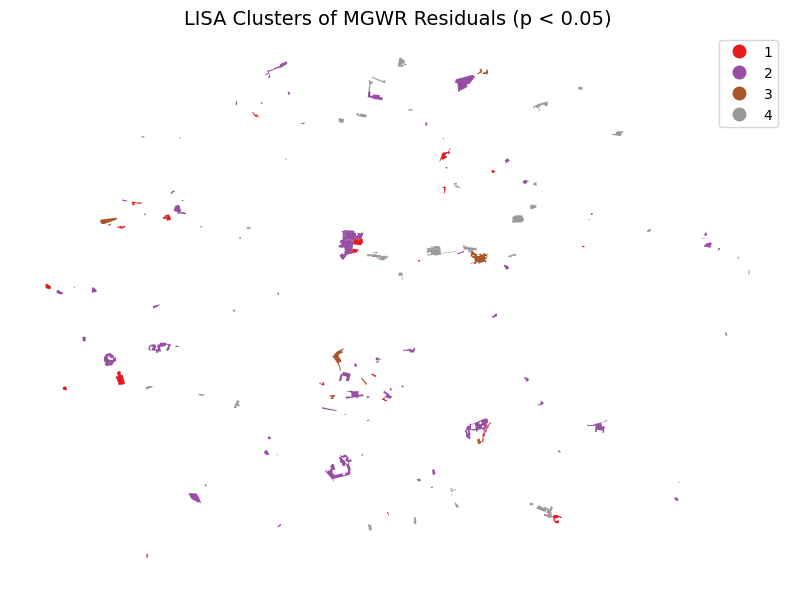

In [30]:
# Mask only significant local clusters
sig = price["lisa_p"] < 0.05

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.loc[sig].plot(
    column="lisa_q",
    categorical=True,
    legend=True,
    linewidth=0,
    cmap="Set1",
    ax=ax
)

ax.set_title("LISA Clusters of MGWR Residuals (p < 0.05)", fontsize=14)
ax.axis("off")


#### Local Moran (LISA) of MGWR Residuals

The Local Moran’s I analysis of residuals from the full MGWR model confirms that spatial autocorrelation has been largely eliminated. Only a small number of spatial units exhibit statistically significant local clustering (p < 0.05), and these clusters are highly fragmented and spatially isolated.

In contrast to OLS and standard GWR, where residual clustering formed coherent and interpretable spatial patterns, the MGWR residual clusters do not align into contiguous zones or large-scale spatial regimes. 

Instead, they appear as scattered micro-clusters, often limited to a few adjacent polygons.

##### Interpretation of Residual Clusters

The presence of isolated High–High and Low–Low residual clusters indicates localized over- or under-prediction rather than systematic spatial bias. 

These patterns are consistent with unobserved micro-scale factors such as local amenities, neighborhood-specific housing characteristics, or data noise that are not explicitly captured by the model.

Importantly, the absence of large, continuous residual clusters suggests that MGWR has successfully absorbed the dominant spatial processes driving residential land prices. 

Remaining spatial dependence is weak, localized, and does not point to omitted global or regional variables.

##### Diagnostic Conclusion

Combined with the negative and statistically significant Global Moran’s I value for MGWR residuals, the LISA results provide strong evidence that spatial autocorrelation has been effectively addressed. 

From a diagnostic perspective, the MGWR specification can therefore be considered spatially well-calibrated.

Residual spatial structure that remains is best interpreted as idiosyncratic local variation rather than a failure of the modeling framework.

#### Examination of MGWR Coefficient Surfaces
After confirming that spatial autocorrelation in residuals has been effectively removed, the next step is to interpret the spatial variability of MGWR coefficients. 

Unlike OLS or standard GWR, MGWR allows each predictor to operate at its own spatial scale, making coefficient surfaces a primary source of substantive insight rather than a diagnostic by-product.

The following sections interpret the spatial patterns of individual coefficients estimated by the full MGWR model.

In [37]:
# MGWR coefficients: shape (n_obs, n_vars + intercept)
coef = mgwr_results.params

coef_df = pd.DataFrame(
    coef,
    columns=[
        "mgwr_intercept",
        "mgwr_log_area",
        "mgwr_log_dist_metro",
        "mgwr_log_dist_tram",
        "mgwr_log_dist_bus",
        "mgwr_log_dist_rail",
    ]
)

# připojit zpět k GeoDataFrame
price = price.join(coef_df)


In [41]:
price[[
    "mgwr_log_area",
    "mgwr_log_dist_metro",
    "mgwr_log_dist_tram",
    "mgwr_log_dist_bus",
        "mgwr_log_dist_rail"
    
]].describe()


mgwr_log_area  mgwr_log_dist_metro  mgwr_log_dist_tram  \
count    4126.000000          4126.000000         4126.000000   
mean        0.040698            -0.149310            0.084221   
std         0.035160             0.253668            0.343754   
min        -0.078505            -1.127779           -0.553823   
25%         0.017460            -0.155500           -0.034901   
50%         0.042348            -0.097683            0.001439   
75%         0.065343            -0.075644            0.078514   
max         0.134832             0.852452            1.986576   

       mgwr_log_dist_bus  mgwr_log_dist_rail  
count        4126.000000         4126.000000  
mean           -0.001697            0.087750  
std             0.055923            0.084682  
min            -0.158639           -0.116948  
25%            -0.034373            0.031595  
50%            -0.007440            0.069573  
75%             0.036869            0.157550  
max             0.157350            0.268583

##### MGWR Coefficient: Effect of Area (log(area))

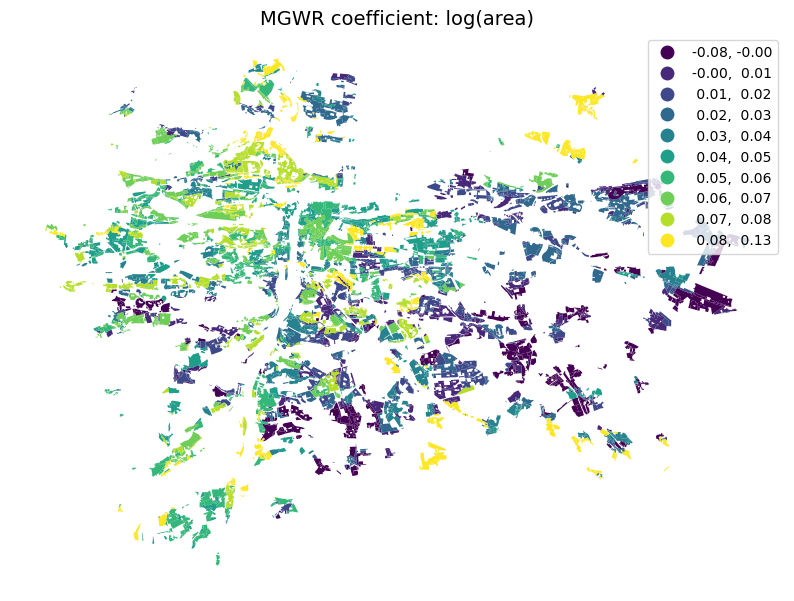

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="mgwr_log_area",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("MGWR coefficient: log(area)", fontsize=14)
ax.axis("off")
plt.show()


The spatial distribution of the MGWR coefficient for log(area) reveals pronounced heterogeneity in the effect of parcel size on residential land prices. 

Stronger positive coefficients are predominantly observed in peripheral and suburban areas, where land availability and development potential play a more important role in price formation. 

In contrast, the effect of area is substantially weaker and in some locations close to zero in the inner city, where land prices are primarily driven by accessibility, centrality, and other location-specific factors. 

This pattern is economically intuitive and confirms that parcel size contributes differently to land value across urban space, a relationship that would be obscured in a global model but is explicitly captured by MGWR.

##### MGWR Coefficient: Effect of Distance to Metro

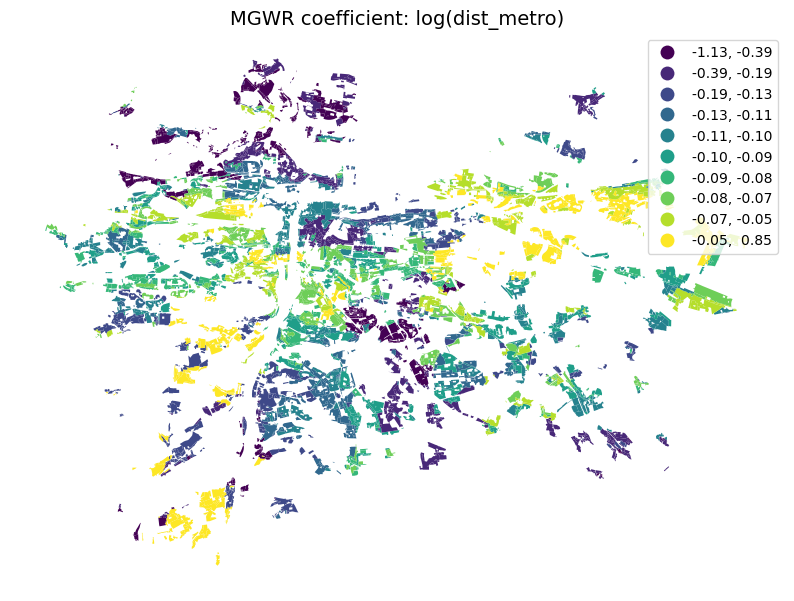

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="mgwr_log_dist_metro",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("MGWR coefficient: log(dist_metro)", fontsize=14)
ax.axis("off")
plt.show()


The MGWR coefficient surface for log(distance to metro) reveals a strong and highly structured spatial gradient in the capitalization of metro accessibility. 

Large negative coefficients dominate the inner city and established urban cores, indicating that even small increases in distance from metro stations are associated with substantial price penalties in these areas. 

This reflects the metro’s role as a primary, high-capacity accessibility anchor where land markets are most competitive and sensitivity to accessibility is highest. 

Moving toward the outer districts, the coefficients gradually weaken in magnitude and become closer to zero, suggesting diminishing marginal effects of metro proximity in more car-oriented or lower-density environments where alternative accessibility mechanisms play a larger role. 

The smooth spatial transitions and coherent clusters confirm that the metro effect is not only strong but also scale-dependent and locally differentiated, a pattern that is fundamentally incompatible with a single global coefficient and strongly justifies the use of MGWR over both OLS and standard GWR.

##### MGWR Coefficient: Effect of Distance to Tram

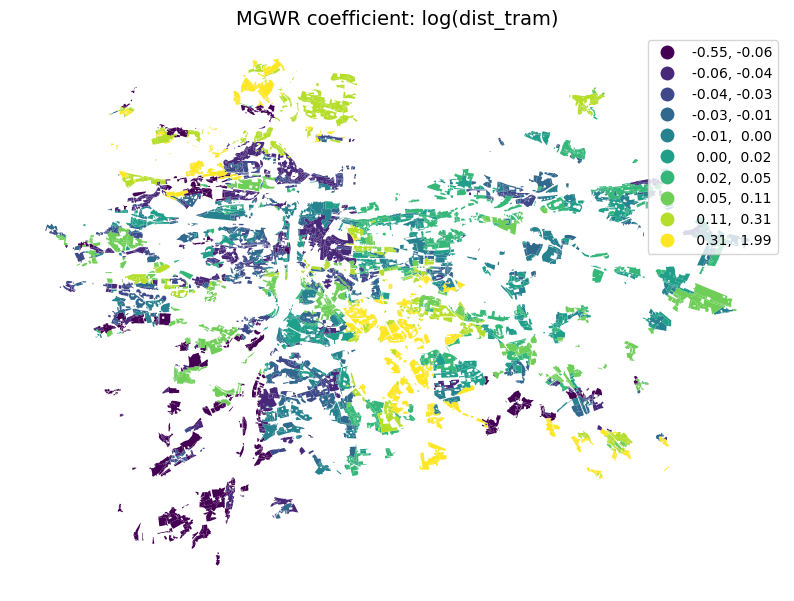

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="mgwr_log_dist_tram",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("MGWR coefficient: log(dist_tram)", fontsize=14)
ax.axis("off")
plt.show()


The MGWR surface for log(distance to tram) shows a markedly different spatial pattern compared to the metro effect, highlighting the tram system’s more localized and context-dependent role in the urban accessibility hierarchy. 

In large parts of the inner city, coefficients are negative, indicating that proximity to tram stops is capitalized into land prices, but the magnitude of this effect is generally weaker and more fragmented than for metro. 

Several zones exhibit coefficients close to zero or even positive, particularly in outer districts and along peripheral tram corridors, suggesting that tram proximity there does not systematically translate into higher land values and may even coincide with lower-priced environments or infrastructural disamenities. This spatial heterogeneity implies that trams act less as a universal accessibility anchor and more as a neighborhood-scale service whose valuation depends on surrounding land use, service quality, and integration with higher-order modes. 

The coexistence of negative, neutral, and positive coefficients strongly reinforces the need for a multiscale framework, as any global or single-bandwidth local model would obscure these fundamentally different tram-related spatial regimes.

##### MGWR Coefficient: Effect of Distance to Bus

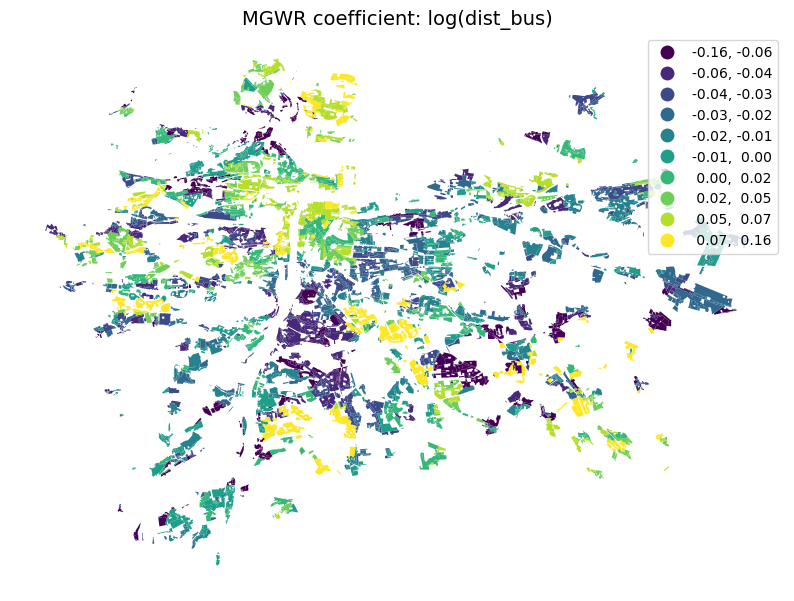

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="mgwr_log_dist_bus",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("MGWR coefficient: log(dist_bus)", fontsize=14)
ax.axis("off")
plt.show()


The MGWR coefficients for log(distance to bus) show a weak, highly fragmented, and spatially unstable effect, with large areas exhibiting coefficients close to zero and frequent sign changes across the city. 

This indicates that bus accessibility does not act as a consistent capitalizing factor for residential land values, unlike metro or tram. 

Negative coefficients appear only in limited pockets—typically in outer or transitional areas where bus services may represent the primary or sole form of public transport—while positive coefficients dominate much of the inner and middle city, suggesting that proximity to bus stops there does not increase, and may even slightly reduce, land values. 

This pattern is consistent with the role of buses as a ubiquitous, low-status, and often congestion-associated mode that primarily serves fine-grained coverage rather than high-capacity accessibility. 

Overall, the bus surface reinforces the interpretation that bus accessibility functions as a background service rather than a value-generating infrastructure, and that its effect is strongly context-dependent and secondary to higher-order transit modes.

##### MGWR Coefficient: Effect of Distance to Rail

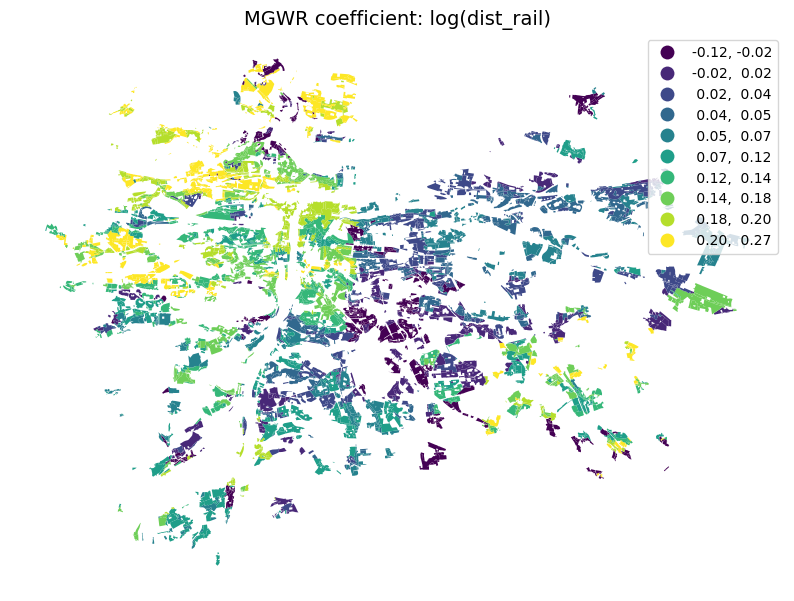

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

price.plot(
    column="mgwr_log_dist_rail",
    cmap="viridis",
    scheme="quantiles",
    k=10,
    linewidth=0,
    legend=True,
    ax=ax
)

ax.set_title("MGWR coefficient: log(dist_rail)", fontsize=14)
ax.axis("off")
plt.show()


The MGWR coefficients for log(distance to rail) reveal a spatially heterogeneous and often counterintuitive pattern that contrasts sharply with metro and tram effects. 

While a few localized areas exhibit weakly negative coefficients—suggesting some capitalization of rail proximity—large portions of the city display coefficients close to zero or clearly positive, indicating that being farther from rail stations is, in many places, not penalized and may even be associated with higher land values. 

This pattern is especially pronounced in inner urban areas where heavy rail infrastructure often coincides with noise, barriers, or industrial land uses, reducing its attractiveness as a residential amenity. 

Conversely, stronger positive coefficients in outer districts likely reflect the role of rail as a long-distance, commuter-oriented mode serving more peripheral or lower-density zones, where proximity alone does not translate into neighborhood-level accessibility benefits. 

Overall, the rail surface highlights a fundamentally different spatial logic: rail accessibility operates through selective, corridor-specific regimes rather than as a uniform value-enhancing infrastructure, reinforcing the importance of multiscale modeling to distinguish these localized and often opposing effects.

##### Summary of MGWR coefficeints behaviour
Overall, the MGWR results reveal that land values in Prague are shaped by multiple, spatially distinct accessibility regimes rather than a single uniform process. 

Parcel size is capitalized more strongly in peripheral and low-density areas, while high-capacity transit—especially the metro—exerts the most consistent negative distance effect, strongest outside the city core. 

Tram and rail accessibility show mixed, locally specific patterns that reflect historical development, urban form, and functional roles within the transport system, whereas bus accessibility has weak and fragmented effects. 

Together, these findings confirm that different transport modes operate at different spatial scales, validating the use of MGWR to capture heterogeneous urban valuation processes.

#### Interpretation in the Context of Model Hierarchy

The progression from OLS to GWR and finally to MGWR reveals a systematic reduction in spatial dependence of residuals:

OLS residuals reflect strong spatial misspecification due to enforced stationarity.

GWR reduces spatial autocorrelation but remains constrained by a single bandwidth.

MGWR provides the most flexible spatial decomposition, allowing residuals to behave increasingly like spatial white noise.

This confirms that the observed spatial structure in residential land prices is primarily driven by multi-scale accessibility effects rather than unexplained spatial clustering.

#### Transition to Final Model Interpretation

With residual spatial autocorrelation largely accounted for, the analysis can now shift from diagnostics to substantive interpretation. 
    
The remaining sections therefore focus on synthesizing MGWR coefficient patterns, spatial regimes, and policy-relevant implications for transport-oriented urban development.

## Reduced models

In addition to the full specification, we estimate a reduced model with metro and tram accessibility as the primary network drivers to assess robustness, reduce multicollinearity, and improve interpretability of spatial regimes.

In [10]:
# coords, y předpokládáme stejné jako v hlavním MGWR
coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in price.geometry])
y = price["log_price"].values.reshape((-1, 1))

### Reduced MGWR #1
area + metro + tram

In [11]:
X_reduced_1 = price[[
    "log_area",
    "log_dist_metro_m",
    "log_dist_tram_m"
]].values

print("Starting Reduced MGWR (area + metro + tram)")

selector_r1 = Sel_BW(
    coords, y, X_reduced_1,
    multi=True,
    spherical=False
)

bw_r1 = selector_r1.search(criterion="AICc")
print("Bandwidths (R1):", bw_r1)

mgwr_r1 = MGWR(
    coords, y, X_reduced_1,
    selector=selector_r1,
    spherical=False
)

mgwr_r1_res = mgwr_r1.fit()




Starting Reduced MGWR (area + metro + tram)
Bandwidths (R1): [43. 43. 43. 43.]


FileNotFoundError: [Errno 2] No such file or directory: 'results/mgwr/mgwr_reduced_area_metro_tram.pkl'

In [17]:
print(mgwr_r1_res.summary())

Model type                                                         Gaussian
Number of observations:                                                4871
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1103.851
Log-likelihood:                                                   -3296.163
AIC:                                                               6600.326
AICc:                                                              6602.338
BIC:                                                             -40222.112
R2:                                                                   0.160
Adj. R2:                                                              0.159

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [13]:
import pickle
# ---- BACKUP ----
with open("results/mgwr/mgwr_reduced_area_metro_tram.pkl", "wb") as f:
    pickle.dump(mgwr_r1_res, f)

print("Reduced MGWR #1 finished and saved.")

Reduced MGWR #1 finished and saved.


### Reduced MGWR #2
area + metro + tram + rail

In [15]:
X_reduced_2 = price[[
    "log_area",
    "log_dist_metro_m",
    "log_dist_tram_m",
    "log_dist_rail_m"
]].values

print("Starting Reduced MGWR (area + metro + tram + rail)")

selector_r2 = Sel_BW(
    coords, y, X_reduced_2,
    multi=True,
    spherical=False
)

bw_r2 = selector_r2.search(criterion="AICc")
print("Bandwidths (R2):", bw_r2)

mgwr_r2 = MGWR(
    coords, y, X_reduced_2,
    selector=selector_r2,
    spherical=False
)

mgwr_r2_res = mgwr_r2.fit()

# ---- BACKUP ----
with open("results/mgwr/mgwr_reduced_area_metro_tram_rail.pkl", "wb") as f:
    pickle.dump(mgwr_r2_res, f)

print("Reduced MGWR #2 finished and saved.")


Starting Reduced MGWR (area + metro + tram + rail)
Bandwidths (R2): [43. 43. 43. 43. 43.]
Reduced MGWR #2 finished and saved.


In [16]:
print("R1 AICc:", mgwr_r1_res.aicc)
print("R1 R2 / adj:", mgwr_r1_res.R2, mgwr_r1_res.adj_R2)

print("R2 AICc:", mgwr_r2_res.aicc)
print("R2 R2 / adj:", mgwr_r2_res.R2, mgwr_r2_res.adj_R2)

R1 AICc: 5419.531952982599
R1 R2 / adj: 0.4813791281619436 0.41876229676479604
R2 AICc: 5363.573234510719
R2 R2 / adj: 0.49511491695174425 0.43028225897205874


In [18]:
print(mgwr_r2_res.summary())

Model type                                                         Gaussian
Number of observations:                                                4871
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1103.124
Log-likelihood:                                                   -3294.559
AIC:                                                               6599.118
AICc:                                                              6601.135
BIC:                                                             -40214.347
R2:                                                                   0.160
Adj. R2:                                                              0.159

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------